# Abstract

## Overview

In February of 2019, tens of thousands of domestic flights carried passengers around the country—every single day. Tens of thousands of aircraft being carefully tracked, monitored, organized and directed, and hundred of thousands or even millions of passengers count on those planes to get them where they're going. It's an incredible system, and most of the time it actually works. But when it doesn't, it hurts. Flight cancellations are extremely expensive, costing airlines a $1 billion per year. While flight cancellations due to weather may be inevitable, a significant portion of cancellations are due to circumstances under _our_ control. Modern air traffic control is a hundred years in the making and has certainly worked to minimize this issue already, but…can we do better?

## Question

Using data on American commercial flights, can we predict when a cancellation is likely to occur? As a bonus, can we predict _why_ the cancellation will occur?


*This is your space to describe your intentions for the project, before writing a single line of code. What are you studying? What are you hoping to build? If you can't explain that clearly before you start digging into the data, you're going to have a hard time planning where to go with this.*

# Obtain the Data

*Describe your data sources here and explain why they are relevant to the problem you are trying to solve.*

*Your code should download the data and save it in data/raw. If you've got the data from an offline source, describe where it came from and what the files look like. Don't do anything to the raw data files just yet; that comes in the next step.*

## Data Sources

My data set will be primarily based around the "[Marketing Carrier On-Time Performance](https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&DB_URL=)" report released by the Bureau of Transportation Statistics. This database contains information on nearly every flight conducted by a significant U.S. carrier dating back to January 2018, which amounts to approximately 8 million observations. I expect I will supplement this dataset with additional features such as weather forecasts preceding a flight and additional statistics surrounding the model of plane for each flight.

### Future Work

Add in data on individual aircraft and type by cross referencing with [this database](https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download/) from the FAA.

*After completing this step, be sure to edit `references/data_dictionary` to include descriptions of where you obtained your data and what information it contains.*

In [7]:
## %%writefile ../src/data/make_dataset.py

# Imports
from io import BytesIO
import os
import urllib.request
from zipfile import ZipFile
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import sqlalchemy
from sqlalchemy import create_engine
import datetime
from pytz import timezone
from datetime import timedelta
import pytz
import json
import requests
import numpy as np
import pandas as pd

# Helper functions


def get_lookup_tables():
    # Reporting carrier lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS'
    # Reporting airline lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRLINE_ID'
    # Airport ID lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT_ID'
    # City Market ID lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_CITY_MARKET_ID'
    # Airport lookup table (SEA -> Seattle-Tacoma International)
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT'
    
    lookups = [
        'L_UNIQUE_CARRIERS',
        'L_AIRLINE_ID',
        'L_AIRPORT_ID',
        'L_CITY_MARKET_ID',
        'L_AIRPORT',
        'L_AIRPORT_ID',
        'L_CITY_MARKET_ID'
    ]
    lookup_base = 'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup='
    for table in lookups:
        download_lookup(lookup_base + table)
    pass


def get_weather_forecast_url(lat, lon, time):
    """
    """
    # Weather forecast API
    'https://darksky.net/dev/docs#time-machine-request'
    key = 'c00a48b4e746f7a6b5a4caef59e18dc9'
    # Example
    base = 'https://api.darksky.net/forecast/'
    tail = '?exclude=currently,flags'
    url = f'{base}{key}/{lat},{lon},{time}{tail}'
    
    return url


def get_weather_data(start_date, end_date, overwrite='ask'):
    """
    """
    if overwrite == 'ask':
        overwrite = input(f'Get weather data? y/n: ')
    if overwrite.lower() != 'y':
        return
    
    table = 'weather'
    params = {
        'user': 'scottbutters',
        'host': '127.0.0.1',
        'port': 5432,
        'dbname': 'raw_flight_data'
    }
    
    connection_string = f"postgresql:///{params['dbname']}"
    engine = create_engine(connection_string)
    
    # SeaTac Coordinates
    lat = 47.4502
    lon = -122.3088
    
    date = end_date
    print(f'Getting weather data for {date} to {end_date}...')
    while date > start_date:
        e_date = date.strftime("%s")
        url = get_weather_forecast_url(lat, lon, e_date)
#         try:
        r = requests.get(url)
        if r.ok:
            day_weather = r.json()
            data = pd.DataFrame(day_weather['hourly']['data'])
            data['datetime'] = pd.to_datetime(data['time'], unit='s')
            data['date'] = data['datetime'].dt.date
            data['hour'] = data['datetime'].dt.hour - 8
            try:
                data.to_sql(table, engine, if_exists='append', index=False)
            except:
                print(f'Failed to append {date} to table.')
        else:
            print(f'No data for {date}. Error {r.status_code}')
        date -= timedelta(days=1)
        if date.strftime('%m-%d') == '01-01':
            year = date.strftime('%Y')
            print(f'Collected data for {year}')
    print(f'Wrote weather data from {start_date} to {end_date} to table {table}')
    return


def file_exists(path, filename):
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    return file_exists

    
def download_dataset(url, path, filename, overwrite='ask'):
    """
    Downloads zip file from specified url and extracts csv file to raw data 
    directory
    Input: 
        url: string of url from which to retrieve data
        path: string of directory path to store file in
        filename: string of desired filename
        overwrite: parameter for whether or not to overwrite existing files, if
            found. If 'y', any existing file with filename in path will be
            overwritten. If 'n', function will do nothing. If 'ask', function
            will prompt user to decide whether or not to replace file.
    Output: dataset stored in raw data directory
    """
    filepath = path + filename
    if file_exists(path, filename):
        if overwrite == 'ask':
            overwrite = input(f'{filename} already exists. Update? y/n: ')
        if overwrite.lower() != 'y':
            return
                              
    print(f'Beginning download of {filename}...')
    try:
        zip_f = urllib.request.urlopen(url)
        with ZipFile(BytesIO(zip_f.read())) as my_zip_file:
            for f in my_zip_file.namelist():
                if '.csv' in f:
                    with open(filepath, 'wb') as output:
                        for line in my_zip_file.open(f).readlines():
                            output.write(line)
        print(f'Successfully wrote {filename} to {path}')
                              
    except urllib.request.HTTPError:
        print(f'Failed to download {filename}')
        return


def get_flight_data_url(year, month):
    '''
    Generate URL to download pre-zipped csv of flight data for a given month as
    provided by the Bureau of Transportation Statistics
    Input: Year in format YYYY (int), Month in format of (M)M, i.e. 3, or 11
    Output: download URL as a string
    '''
    base_url = 'http://transtats.bts.gov/PREZIP/'
    tail = 'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_'
    slug = f'{year}_{month}.zip'
    return base_url + tail + slug
    

def get_flight_data(start, end, path, overwrite='ask'):
    '''
    Downloads a variety of flight data tables from:
    https://www.transtats.bts.gov/Fields.asp
    '''
    # Download all BTS datasets
    for year in range(start, end):
        for month in range(1,13):
            filename = f'flight_data_{year}-{month}.csv'
            url = get_flight_data_url(year, month)
            download_dataset(url, path, filename, overwrite)
    pass


def run():
    """
    Executes a set of helper functions that download data from one or more sources
    and saves those datasets to the data/raw directory.
    """
    path = '../data/raw/'
#     get_flight_data(2003, 2020, path, overwrite='n')
    
    pacific = timezone('US/Pacific')
    start = datetime.datetime(2003, 1, 1, 0, 0, 0, tzinfo=pacific)
    end = datetime.datetime(2019, 4, 30, 0, 0, 0, tzinfo=pacific)
    get_weather_data(start, end, overwrite='ask')
    # download_dataset_1(url)
    # download_dataset_2(url)
    # save_dataset_1('data/raw', filename)
    # save_dataset_2('data/raw', filename)
    pass

In [8]:
run()

Get weather data? y/n: y
Getting weather data for 2019-04-30 00:00:00-07:53 to 2019-04-30 00:00:00-07:53...
Failed to append 2019-03-08 00:00:00-07:53 to table.
Failed to append 2019-03-07 00:00:00-07:53 to table.
Failed to append 2019-02-11 00:00:00-07:53 to table.
Failed to append 2019-02-10 00:00:00-07:53 to table.
Failed to append 2019-02-09 00:00:00-07:53 to table.
Failed to append 2019-02-08 00:00:00-07:53 to table.
Failed to append 2019-02-06 00:00:00-07:53 to table.
Failed to append 2019-02-05 00:00:00-07:53 to table.
Failed to append 2019-02-04 00:00:00-07:53 to table.
Failed to append 2019-02-03 00:00:00-07:53 to table.
Collected data for 2019
Failed to append 2018-02-25 00:00:00-07:53 to table.
Failed to append 2018-02-24 00:00:00-07:53 to table.
Failed to append 2018-02-23 00:00:00-07:53 to table.
Failed to append 2018-02-22 00:00:00-07:53 to table.
Failed to append 2018-02-18 00:00:00-07:53 to table.
Collected data for 2018
Failed to append 2017-12-26 00:00:00-07:53 to tab

# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

## Features
The following is a list of features I'd like to have in the design matrix:


| Feature                               | Description                                                  | Type        | Purpose |
| ------------------------------------- | ------------------------------------------------------------ | ----------- | ------- |
| Airline ID                            | ID number to identify unique airline                         | Categorical | Key     |
| AL_C_rate_day                         | Flight cancellation rate by this airline at this airport over past 24 hours | Continuous  | Feature |
| AL_C_rate_7                           | Flight cancellation rate by this airline on this weekday 1 week ago | Continuous  | Feature |
| AL_C_avg_rate_week                    | Flight cancellation rate by this airline at this airport over past 7 days | Continuous  | Feature |
| AL_C_rate_28                          | Flight cancellation rate by this airline on this weekday 4 weeks ago | Continuous  | Feature |
| AL_C_avg_rate_month                   | Flight cancellation rate by this airline at this airport over past 30 days | Continuous  | Feature |
| AL_C_rate_364                         | Flight cancellation rate by this airline on this weekday 52 weeks ago | Continuous  | Feature |
| AL_C_avg_rate_year                    | Flight cancellation rate by this airline at this airport over past 365 days | Continuous  | Feature |
| Tail number                           | Unique airplane identifier ID                                | Categorical | Key     |
| AP_C_rate_day                         | Flight cancellation rate by this airplane over past 24 hours | Continuous  | Feature |
| AP_C_rate_7                           | Flight cancellation rate by this airplane on this weekday 1 week ago | Continuous  | Feature |
| AP_C_avg_rate_week                    | Flight cancellation rate by this airplane at this airport over past 7 days | Continuous  | Feature |
| AP_C_rate_28                          | Flight cancellation rate by this airplane on this weekday 4 weeks ago | Continuous  | Feature |
| AP_C_avg_rate_month                   | Flight cancellation rate by this airplane at this airport over past 30 days | Continuous  | Feature |
| AP_C_rate_364                         | Flight cancellation rate by this airplane on this weekday 52 weeks ago | Continuous  | Feature |
| AP_C_avg_rate_year                    | Flight cancellation rate by this airplane at this airport over past 365 days | Continuous  | Feature |
| Origin Airport ID                     | Unique airport identifier ID for flight origin               | Categorical | Key     |
| orig_C_rate_day                       | Flight cancellation rate for flights departing from origin airport over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Origin City Market                    | ID for area that may be served by several airlines           | Categorical | Key     |
| OCM_C_rate_day                        | Flight cancellation rate for flights departing from origin city market over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Dest Airport ID                       | Unique airport identifier ID for destination                 | Categorical | Key     |
| dest_C_rate_day                       | Flight cancellation rate for flights heading to destination airport over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Dest City Market                      | ID for area that may be served by several airlines           | Categorical | Key     |
| DCM_C_rate_day                        | Flight cancellation rate for flights heading to destination city market over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Departure time                        | Scheduled departure time                                     | ?           |         |
| Airtime                               | Planned time in air, in minutes                              | Continuous  |         |
| Distance                              | Planned route distance                                       | Continuous  |         |
| On-time incoming arrival percentage   | Percent of flights that arrive at departure airport on-time  | Continuous  |         |
| On-time outgoing departure percentage | Percent of flights that depart from departure airport on-time | Continuous  |         |
| Historical cancellation percentages   | All time average                                             | Continuous  |         |
|                                       | 1 day ago                                                    | Continuous  |         |
|                                       | 7 days ago                                                   | Continuous  |         |
|                                       | 30 days ago                                                  | Continuous  |         |
|                                       | 364 days ago                                                 | Continuous  |         |
|                                       | For this airline                                             | Continuous  |         |
|                                       | From this airport                                            | Continuous  |         |
|                                       | To that airport                                              | Continuous  |         |
|                                       | On this airplane (tail number)                               | Continuous  |         |
|                                       | On this airplane model                                       | Continuous  |         |
| Historical delays (goes back to 2003) | The average number of minutes that a similar incoming flight has been delayed (in minutes) over the avove time periods, for the reasons: carrier delay, weather delay, national air system delay, security delay, and late aircraft delay |             |         |
|                                       |                                                              |             |         |
| Weather Forecast                      | What the weather forecast was ~24 hours ago, in degrees      | Continuous  |         |
| Other airline/craft statistics        |                                                              |             |         |
| Cancelled                             | Boolean for whether or not flight is cancelled, 1=Yes        | Boolean     |         |
| Cancellation Code                     | Reason for cancellation (carrier, weather, national air system, security) | Categorical |         |



## Process

In [147]:
# %%writefile ../src/features/build_features.py

# Imports
import csv
from os import listdir
import subprocess
import sys
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import sqlalchemy
from sqlalchemy import create_engine
import numpy as np
import pandas as pd


# Helper functions
def export_design_matrix(df):
    """
    Pickles design matrix and stores in processed directory to be trained on
    Input: clean design matrix df containing only features and target
    Outpu: pickled design matrix in data directory
    """
    display(df.head(), df.tail())
    df.to_pickle('../data/processed/data.pkl')
    pass


def get_day(cols, engine):
    select = ', '.join([f'"{col}"' for col in cols])
    q = f"""
    SELECT  
        LPAD((hour + 8) || '00-', 5, '0') || LPAD((hour + 8) || '59', 4, '0') AS deptimeblk,
        date + 1 AS next_day,
        {select}
    FROM weather 
    WHERE hour BETWEEN -2 AND 16
    ;"""
    day = pd.read_sql(q, engine)
    return day

    
def get_morning(engine):
    cols = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
           'ozone', 'precipIntensity', 'precipProbability',
           'pressure', 'temperature', 'uvIndex', 'visibility',
           'windBearing', 'windGust', 'windSpeed']
    calls = ' '.join([f'AVG("{col}") AS "{col}",' for col in cols])
    q = f"""
    SELECT 
        {calls}
        date + 1 AS next_day,
        '0001-0559' AS deptimeblk
    FROM weather
    WHERE hour BETWEEN -8 AND -3
    GROUP BY date
    ORDER BY date DESC;
    """
    morning = pd.read_sql(q, engine)
    return morning


def add_forecast(weather):
    """
    
    """
    data = weather.copy()
    data.to_pickle('../data/weather_test.pkl')
#     data['date'] = pd.to_datetime(weather['next_day']) - pd.Timedelta('1 day')
    data['date'] = data['next_day'] - pd.Timedelta('1 day')
    data = data.set_index(['date', 'deptimeblk'])
#     display(data.columns, data.head())
    data = data.drop('next_day', axis=1)

    # Define noise matrix
    mu, sigma = 1, 0.025 
    noise = np.random.normal(mu, sigma, data.shape)
    
    forecast = data * noise
    forecast.columns = [f'forecast_{col}' for col in forecast.columns]
    forecast.reset_index
    
#     weather['date'] = pd.to_datetime(weather['next_day'])
    weather['date'] = weather['next_day']
    weather = weather.merge(
        forecast, how='left', on=['date', 'deptimeblk']
    ).drop('next_day', axis=1)
    
    return weather

def get_weather(engine):
    morning = get_morning(engine)
    
    day_cols = morning.columns.drop(['next_day', 'deptimeblk'])
    day = get_day(day_cols, engine)

    weather = pd.concat((morning, day), keys='next_day')

    drop_cols = ['ozone']#'summary', 'precipType', 'icon']
    weather = weather.drop(columns=drop_cols)
    return weather.sort_values(by=['next_day', 'deptimeblk'])


def rolling_average_CR(engine, days, by=''):
    col = ''
    name = ''
    if by:
        col = f'{by},'
        name = f'_by_{by}'
    q = f"""
    SELECT 
        CAST(flightdate AS DATE) + 1 as date,
        {col}
        cancelled
    FROM flights f
    WHERE
        origin='SEA'
    ORDER BY flightdate
    ;"""

    df = pd.read_sql(q, engine)
    
    if by:
        aggs = df.groupby(['date', by])['cancelled'].agg(['count', 'sum'])
    else:
        aggs = df.groupby('date')['cancelled'].agg(['count', 'sum'])
    
    rolls = aggs.rolling(days).sum()
    rolls[f'{days}_day_CR_avg{name}'] = rolls['sum'] / rolls['count']
    
    return rolls.iloc[:, -1].reset_index()


def get_group_CR(engine, by=''):
    """
    """
    col = ''
    group = ''
    part = ''
    if by:
        col = f'{by},'
        group = f'{by}, '
        part = f'PARTITION BY {by} '
        by = f'{by}_'
        
    q = f"""
    SELECT 
        CAST(flightdate AS DATE) AS date,
        {col}
        LAG(AVG(cancelled), 1) OVER(
            {part}ORDER BY flightdate) AS {by}CR_1d_ago,
        LAG(AVG(cancelled), 7) OVER(
            {part}ORDER BY flightdate) AS {by}CR_1w_ago,
        LAG(AVG(cancelled), 28) OVER(
            {part}ORDER BY flightdate) AS {by}CR_4w_ago,
        LAG(AVG(cancelled), 364) OVER(
            {part}ORDER BY flightdate) AS {by}CR_52w_ago
    FROM flights
    WHERE 
        origin = 'SEA'
    GROUP BY {group}flightdate
    ORDER BY flightdate
    ;"""
    df = pd.read_sql(q, engine)
    return df


def build_design_matrix(engine):
    """
    """
    print('Building design matrix...')
    dm = """
    SELECT
        CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
            AS flight,
        CAST(flightdate AS DATE) AS date,
        cancelled,
        crselapsedtime AS est_time,
        distance,
        reporting_airline,
        tail_number,
        dest,
        destcitymarketid,
        deptimeblk,
        arrtimeblk
    FROM flights
    WHERE flightdate between '2007-01-01' AND '2018-12-31' AND
        origin = 'SEA'
    ORDER BY date
    ;"""
    df = pd.read_sql(dm, engine, index_col='flight')
    return df


def build_features(engine):
    """
    """
    df = build_design_matrix(engine)
    
    # Columns to aggregate by
    cols = ['reporting_airline', 'dest', 'destcitymarketid', 
            'deptimeblk', 'arrtimeblk', 'tail_number']
    
    # Get lag cancellation rates
    print('Getting lag cancellation rates')
    overwrite = 'y'
    if overwrite == 'ask':
        overwrite = input(f'Recalculate lag cancellation rate data?')
    if overwrite.lower() == 'y':
        lag = get_group_CR(engine)
        df = df.merge(lag, how='left', on='date')

        for col in cols:
            try:
                lag = get_group_CR(engine, col)
                df = df.merge(lag, how='left', on=['date', col])
            except:
                print(f'Failed to generate lag_CRs for {col}')
        df.to_pickle('../data/processed/df_w_lag_CRs.pkl')
    else:
        df = pd.read_pickle('../data/processed/df_w_lag_CRs.pkl')
        
    # Get rolling average cancellation rates
    print('Getting rolling average cancellation rates')
    cols.remove('tail_number')
    overwrite = 'y'
    if overwrite == 'ask':
        overwrite = input(f'Recalculate rolling average cancellation rate data?')
    if overwrite.lower() == 'y':
        for day in [7, 30, 365]:
            roll = rolling_average_CR(engine, day)
            df = df.merge(roll, how='left', on='date')
            for col in cols:
                try:
                    roll = rolling_average_CR(engine, day, col)
                    df = df.merge(roll, how='left', on=['date', col])
                except:
                    print(f'Failed to generate rolling_average_CRs for {col}')
        df.to_pickle('../data/processed/df_w_CRs.pkl')
    else:
        df = pd.read_pickle('../data/processed/df_w_CRs.pkl')

    # Get weather data
    print('Getting weather data')
    overwrite = 'y'
    if overwrite == 'ask':
        overwrite = input(f'Recalculate weather rate data?')
    if overwrite.lower() == 'y':
        weather = get_weather(engine)
    #     weather = df.rename(columns={'next_day': 'date'})
        weather['next_day'] = pd.to_datetime(weather['next_day'])
    #     weather = weather.drop('next_day', axis=1)
        weather = add_forecast(weather)

        # Merge weather data
        df['date'] = pd.to_datetime(df['date'])
        df = df.merge(weather, how='left', on=['date', 'deptimeblk'])
    #     df = df.merge(weather, how='left', 
    #                   left_on=['date', 'deptimeblk'],
    #                   right_on=['next_day', 'deptimeblk']
    #                  )
        df.to_pickle('../data/processed/df_w_weather.pkl')
    else:
        df = pd.read_pickle('../data/processed/df_w_weather.pkl')
    
    # Make dummies for departure time blocks
    df = pd.concat((df, pd.get_dummies(df['deptimeblk'], drop_first=True)), 
                   axis=1)
    df = df.set_index(pd.DatetimeIndex(df['date']))

    drop_cols = cols + ['date', 'tail_number_cr_52w_ago', 'tail_number']#, 'next_day'
    df = df.drop(drop_cols, axis=1)
    df = df.dropna(thresh=(df.shape[1] - 4))
    df = df.dropna()
    return df

def run_query(query, params, engine):
    '''
    Opens a connection to database to run a query, q
    Input: 
        query (str), a SQL command that requests output
        params (dict), parameters for connecting to psql, including user, host,
            and port
    Output: a pandas dataframe containing the query output
    '''
    return pd.read_sql(query, engine)

    
def show_tables(params):
    # Returns a list of all tables and views in our database
    q = """
    SELECT tablename 
    FROM pg_catalog.pg_tables 
    WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';
    """
    return run_query(q, params)


def run_command(command, params):
    '''
    Opens a connection to database to run a command with no output
    Input: 
        command (str), a SQL query that commits an action
        params (dict), parameters for connecting to psql, including user, host,
            and port
    '''
    with connect(**params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        cur = conn.cursor()
        cur.execute(command)
        pass
    
    
def check_table_exists(table, cursor):
    '''
    Executes a query and checks if item is in returned results
    Input: 
        query (str), a SQL query returning list of items to look within
        item (str), the name of the item to check if exists
        cursor, a psycogp2 cursor object
    Output: boolean, True if item exists
    '''
    query = """
    SELECT tablename 
    FROM pg_catalog.pg_tables 
    WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';
    """
    cursor.execute(query)
    items = [i[0] for i in cursor.fetchall()]
#     print(f'Found tables: {items}')
    exists = table in items
    return exists


def make_table(path, file, engine, table):
    df = pd.read_csv(path + file)

    drop_cols = [
        'DOT_ID_Reporting_Airline',
        'IATA_CODE_Reporting_Airline', 
        'OriginAirportSeqID', 
        'OriginStateFips',
        'OriginWac',
        'DestAirportSeqID', 
        'DestStateFips',
        'DestWac',
        'TaxiOut',
        'WheelsOff', 
        'WheelsOn', 
        'TaxiIn'
    ]

    short_df = df[df.columns[:61]].drop(drop_cols, axis=1)

    shorter_df = short_df[
        short_df['Origin'].str.contains('SEA') |
        short_df['Dest'].str.contains('SEA')
    ]

    index = (shorter_df['FlightDate'].astype(str) 
             + '_' + shorter_df['Flight_Number_Reporting_Airline'].astype(str))

    shorter_df.set_index(
        keys=index,
        inplace=True
    )

    shorter_df.columns = [col.lower() for col in shorter_df.columns]
    
    # Define types
    types = {
        'year': sqlalchemy.types.INTEGER(),
        'quarter': sqlalchemy.types.INTEGER(),
        'month': sqlalchemy.types.INTEGER(),
        'dayofmonth': sqlalchemy.types.INTEGER(),
        'dayofweek': sqlalchemy.types.INTEGER(),
        'flightdate': sqlalchemy.DateTime(),
        'reporting_airline': sqlalchemy.types.VARCHAR(),
        'tail_number': sqlalchemy.types.VARCHAR(),
        'flight_number_reporting_airline': sqlalchemy.types.VARCHAR(),
        'originairportid': sqlalchemy.types.VARCHAR(),
        'origincitymarketid': sqlalchemy.types.VARCHAR(),
        'origin': sqlalchemy.types.VARCHAR(),
        'origincityname': sqlalchemy.types.VARCHAR(),
        'originstate': sqlalchemy.types.VARCHAR(),
        'originstatename': sqlalchemy.types.VARCHAR(),
        'destairportid': sqlalchemy.types.VARCHAR(),
        'destcitymarketid': sqlalchemy.types.VARCHAR(),
        'dest': sqlalchemy.types.VARCHAR(),
        'destcityname': sqlalchemy.types.VARCHAR(),
        'deststate': sqlalchemy.types.VARCHAR(),
        'deststatename': sqlalchemy.types.VARCHAR(),
        'crsdeptime': sqlalchemy.types.INTEGER(),
        'deptime': sqlalchemy.types.INTEGER(),
        'depdelay': sqlalchemy.types.INTEGER(),
        'depdelayminutes': sqlalchemy.types.INTEGER(),
        'depdel15': sqlalchemy.types.BOOLEAN(),
        'departuredelaygroups': sqlalchemy.types.INTEGER(),
        'deptimeblk': sqlalchemy.types.VARCHAR(),
        'crsarrtime': sqlalchemy.types.INTEGER(),
        'arrtime': sqlalchemy.types.INTEGER(),
        'arrdelay': sqlalchemy.types.INTEGER(),
        'arrdelayminutes': sqlalchemy.types.INTEGER(),
        'arrdel15': sqlalchemy.types.BOOLEAN(),
        'arrivaldelaygroups': sqlalchemy.types.INTEGER(),
        'arrtimeblk': sqlalchemy.types.VARCHAR(),
        'cancelled': sqlalchemy.types.INTEGER(),
        'cancellationcode': sqlalchemy.types.VARCHAR(),
        'diverted': sqlalchemy.types.VARCHAR(),
        'crselapsedtime': sqlalchemy.types.VARCHAR(),
        'actualelapsedtime': sqlalchemy.types.INTEGER(),
        'airtime': sqlalchemy.types.INTEGER(),
        'flights': sqlalchemy.types.INTEGER(),
        'distance': sqlalchemy.types.INTEGER(),
        'distancegroup': sqlalchemy.types.INTEGER(),
        'carrierdelay': sqlalchemy.types.VARCHAR(),
        'weatherdelay': sqlalchemy.types.VARCHAR(),
        'nasdelay': sqlalchemy.types.VARCHAR(),
        'securitydelay': sqlalchemy.types.VARCHAR(),
        'lateaircraftdelay': sqlalchemy.types.VARCHAR(),
    }
                  
    # Add to SQL table
    shorter_df.to_sql(
        table, engine, if_exists='append', dtype=types, index=False)
    print(f'Added {file} to table {table}')
                  
    int_path = '../data/interim/'
    shorter_df.to_csv(f'{int_path}reduced_{file}')
    print(f'Wrote {file} to {int_path}')
    pass

                  
def check_db_exists(db, cursor):
    '''
    Executes a query and checks if item is in returned results
    Input: 
        query (str), a SQL query returning list of items to look within
        item (str), the name of the item to check if exists
        cursor, a psycogp2 cursor object
    Output: boolean, True if item exists
    '''
    query = 'SELECT datname FROM pg_database;'
    cursor.execute(query)
    items = [i[0] for i in cursor.fetchall()]
#     print(f'Found items: {items}')
    exists = db in items
    return exists
                  
                  
def create_db(dbname, params):
    '''
    Connects to psql as default user and creates new database if it doesn't
    already exist
    Input:
        dbname (string), name of new database
        params (dict), parameters for connecting to psql, including user, host,
        and port
    Output: database created in psql
    '''
    
    temp_params = params.copy()
    temp_params['dbname'] = 'postgres'
    with connect(**temp_params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        cur = conn.cursor()
        exists = check_db_exists(dbname, cur)
        if not exists:
            cur.execute(f'CREATE DATABASE {dbname}')
            print(f'Created database {dbname}')
    pass
        

def build_raw_database(params, engine, overwrite='ask'):
    '''
    Constructs database from raw data CSVs previously downloaded
    '''
    path = '../data/raw/'

    create_db(dbname=params['dbname'], params=params)
    table_name = 'flights'
    
    # Check whether table exists and prompt about dropping
    with connect(**params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        print(f"Connecting to database {params['dbname']}")
        cur = conn.cursor()
        exists = check_table_exists(table_name, cur)
        if exists:
            if overwrite == 'ask':
                overwrite = input(f'{table_name} already exists. Update? y/n:')
            if overwrite.lower() != 'y':
                return
            run_command('DROP TABLE flights;', params)

    # Collect list of csvs
    files = [f for f in listdir(path) if '.csv' in f]
    files = sorted(files)
    
    # Shrink files and load all into SQL table
    for file in files:
        make_table(path, file, engine, table_name)
    pass
        
def run():
    """
    Executes a set of helper functions that read files from data/raw, cleans them,
    and converts the data into a design matrix that is ready for modeling.
    """
    params = {
        'user': 'scottbutters',
        'host': '127.0.0.1',
        'port': 5432,
        'dbname': 'raw_flight_data'
    }
    
    connection_string = f"postgresql:///{params['dbname']}"
    engine = create_engine(connection_string)
              
    build_raw_database(params, engine, overwrite='n')
    data = build_features(engine)
    export_design_matrix(data)
    return data

## Load Data

In [148]:
%time data = run()
display(data.shape, data.head(), data.info())

Connecting to database raw_flight_data
Building design matrix...
Getting lag cancellation rates
Getting rolling average cancellation rates
Getting weather data


cancelled est_time  distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                        
2007-01-01          0    320.0      2553   0.007407   0.010676   0.010601   
2007-01-01          0    161.0      1050   0.007407   0.010676   0.010601   
2007-01-01          0    219.0      1449   0.007407   0.010676   0.010601   
2007-01-01          0    193.0      1399   0.007407   0.010676   0.010601   
2007-01-01          0    173.0      1216   0.007407   0.010676   0.010601   

            cr_52w_ago  reporting_airline_cr_1d_ago  \
date                                                  
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   

            reporting_airline_cr_1w_ago  reporting_airline_cr_4w_ago  ...  \
date                                                                  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.125                     0.000000  ...   
2007-01-01                        0.000                     0.023438  ...   

            1400-1459  1500-1559  1600-1659  1700-1759  1800-1859  1900-1959  \
date                                                                           
2007-01-01          0          0          0          0          0          0   
2007-01-01          0          1          0          0          0          0   
2007-01-01          0          0          0          0          1          0   
2007-01-01          0          1          0          0          0          0   
2007-01-01          0          0          0          0          0          0   

            2000-2059  2100-2159  2200-2259  2300-2359  
date                                                    
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  

[5 rows x 92 columns]

cancelled est_time  distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                        
2018-12-31          0    158.0       954   0.002688        0.0        0.0   
2018-12-31          0    278.0      2182   0.002688        0.0        0.0   
2018-12-31          0    274.0      2182   0.002688        0.0        0.0   
2018-12-31          0    145.0       867   0.002688        0.0        0.0   
2018-12-31          0    145.0       867   0.002688        0.0        0.0   

            cr_52w_ago  reporting_airline_cr_1d_ago  \
date                                                  
2018-12-31         0.0                     0.000000   
2018-12-31         0.0                     0.000000   
2018-12-31         0.0                     0.000000   
2018-12-31         0.0                     0.000000   
2018-12-31         0.0                     0.005917   

            reporting_airline_cr_1w_ago  reporting_airline_cr_4w_ago  ...  \
date                                                                  ...   
2018-12-31                          0.0                          0.0  ...   
2018-12-31                          0.0                          0.0  ...   
2018-12-31                          0.0                          0.0  ...   
2018-12-31                          0.0                          0.0  ...   
2018-12-31                          0.0                          0.0  ...   

            1400-1459  1500-1559  1600-1659  1700-1759  1800-1859  1900-1959  \
date                                                                           
2018-12-31          0          1          0          0          0          0   
2018-12-31          0          0          0          0          0          0   
2018-12-31          0          0          0          0          0          0   
2018-12-31          0          1          0          0          0          0   
2018-12-31          0          1          0          0          0          0   

            2000-2059  2100-2159  2200-2259  2300-2359  
date                                                    
2018-12-31          0          0          0          0  
2018-12-31          0          0          0          0  
2018-12-31          0          0          1          0  
2018-12-31          0          0          0          0  
2018-12-31          0          0          0          0  

[5 rows x 92 columns]

CPU times: user 3min 29s, sys: 26.4 s, total: 3min 55s
Wall time: 3min 31s
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1202639 entries, 2007-01-01 to 2018-12-31
Data columns (total 92 columns):
cancelled                              1202639 non-null int64
est_time                               1202639 non-null object
distance                               1202639 non-null int64
cr_1d_ago                              1202639 non-null float64
cr_1w_ago                              1202639 non-null float64
cr_4w_ago                              1202639 non-null float64
cr_52w_ago                             1202639 non-null float64
reporting_airline_cr_1d_ago            1202639 non-null float64
reporting_airline_cr_1w_ago            1202639 non-null float64
reporting_airline_cr_4w_ago            1202639 non-null float64
reporting_airline_cr_52w_ago           1202639 non-null float64
dest_cr_1d_ago                         1202639 non-null float64
dest_cr_1w_ago                    

(1202639, 92)

cancelled est_time  distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                        
2007-01-01          0    320.0      2553   0.007407   0.010676   0.010601   
2007-01-01          0    161.0      1050   0.007407   0.010676   0.010601   
2007-01-01          0    219.0      1449   0.007407   0.010676   0.010601   
2007-01-01          0    193.0      1399   0.007407   0.010676   0.010601   
2007-01-01          0    173.0      1216   0.007407   0.010676   0.010601   

            cr_52w_ago  reporting_airline_cr_1d_ago  \
date                                                  
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   
2007-01-01     0.00339                          0.0   

            reporting_airline_cr_1w_ago  reporting_airline_cr_4w_ago  ...  \
date                                                                  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.000                     0.023438  ...   
2007-01-01                        0.125                     0.000000  ...   
2007-01-01                        0.000                     0.023438  ...   

            1400-1459  1500-1559  1600-1659  1700-1759  1800-1859  1900-1959  \
date                                                                           
2007-01-01          0          0          0          0          0          0   
2007-01-01          0          1          0          0          0          0   
2007-01-01          0          0          0          0          1          0   
2007-01-01          0          1          0          0          0          0   
2007-01-01          0          0          0          0          0          0   

            2000-2059  2100-2159  2200-2259  2300-2359  
date                                                    
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  
2007-01-01          0          0          0          0  

[5 rows x 92 columns]

None

*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [35]:
## %%writefile ../src/visualization/visualize.py

# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# helper functions go here
def plot_features(df, target, sample_size=2000):
    features = df.drop(target, axis=1)
    num = features.shape[1]
    n = 5
    for i in range(num//n):
        data = features.iloc[:, i:i+n]
        data[target] = df[target]
        sample = (data.sample(2000, random_state=44)) 
        sns.pairplot(
            sample,
            hue='cancelled', 
            plot_kws=dict(alpha=.3, edgecolor='none'))


def load_features(filepath):
    """
    Loads data from csv and returns as dataframe
    Input: relative filepath pointing to file
    Output: dataframe containing data from csv
    """
    data = pd.read_pickle(filepath)
    return data


def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    target = 'cancelled'
    data = load_features('../data/processed/data.pkl')
    plot_features(data, target)
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    return data


CPU times: user 48.1 s, sys: 817 ms, total: 48.9 s
Wall time: 48.5 s


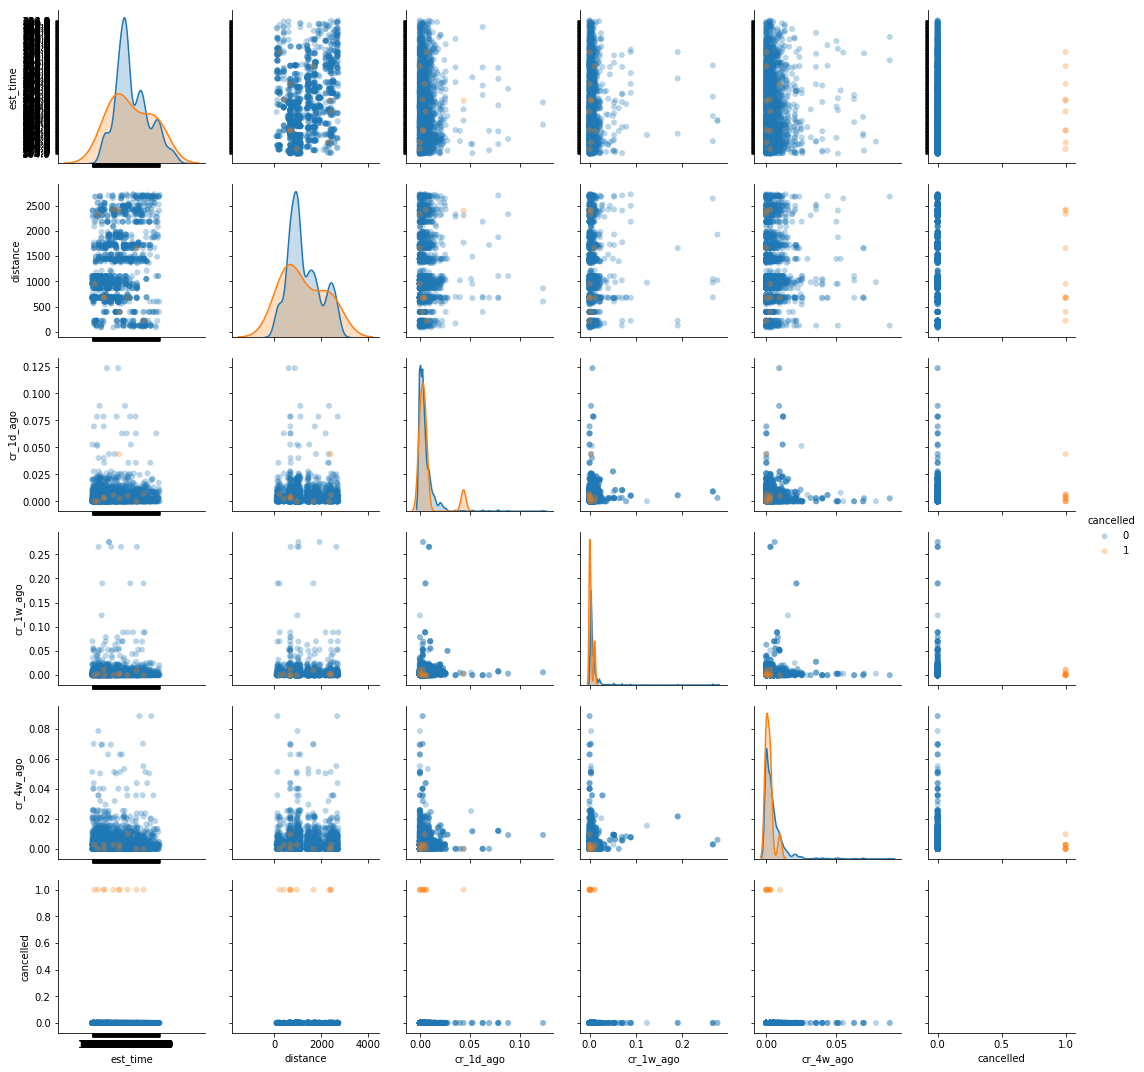

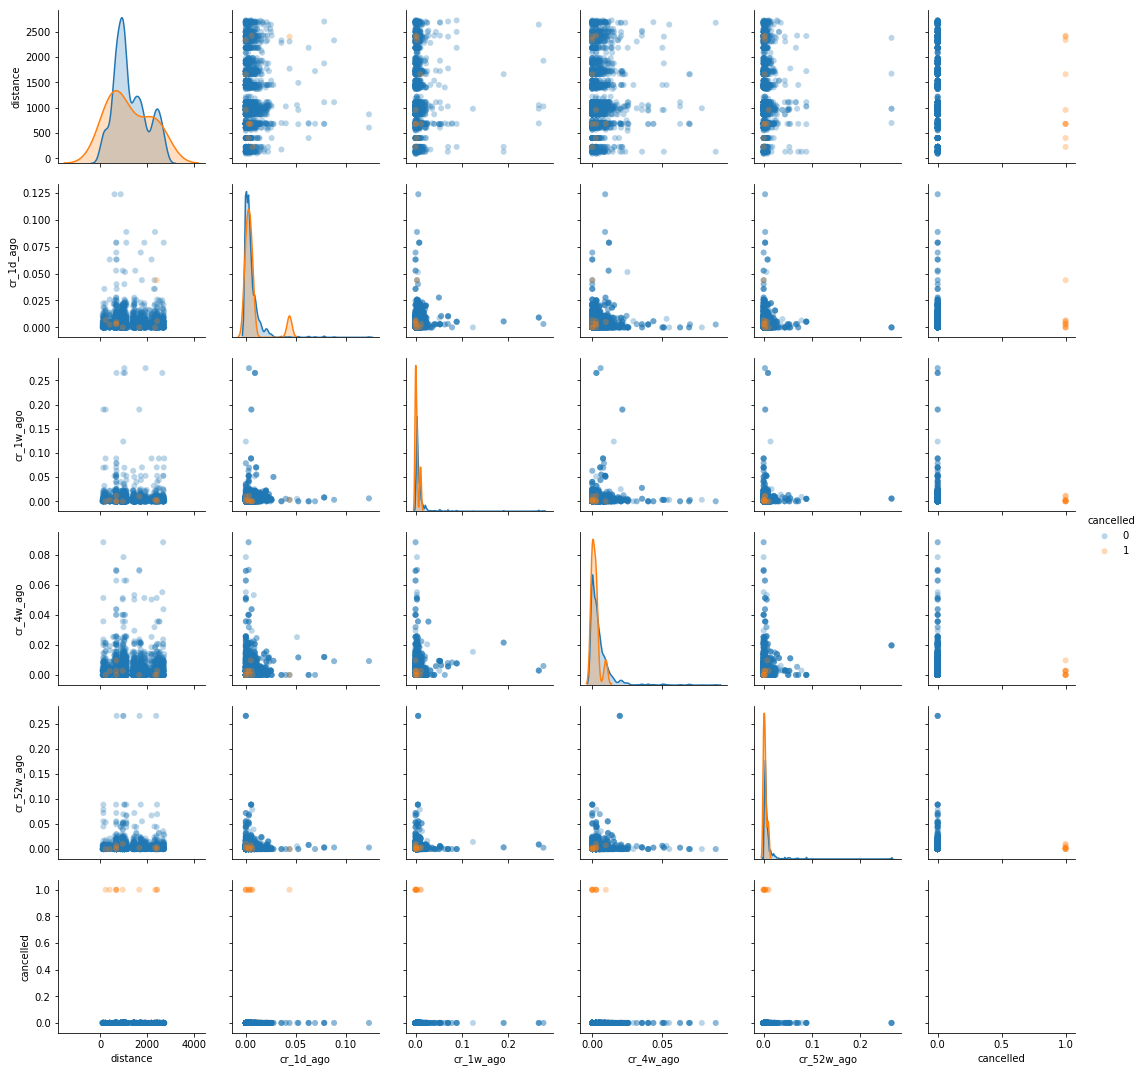

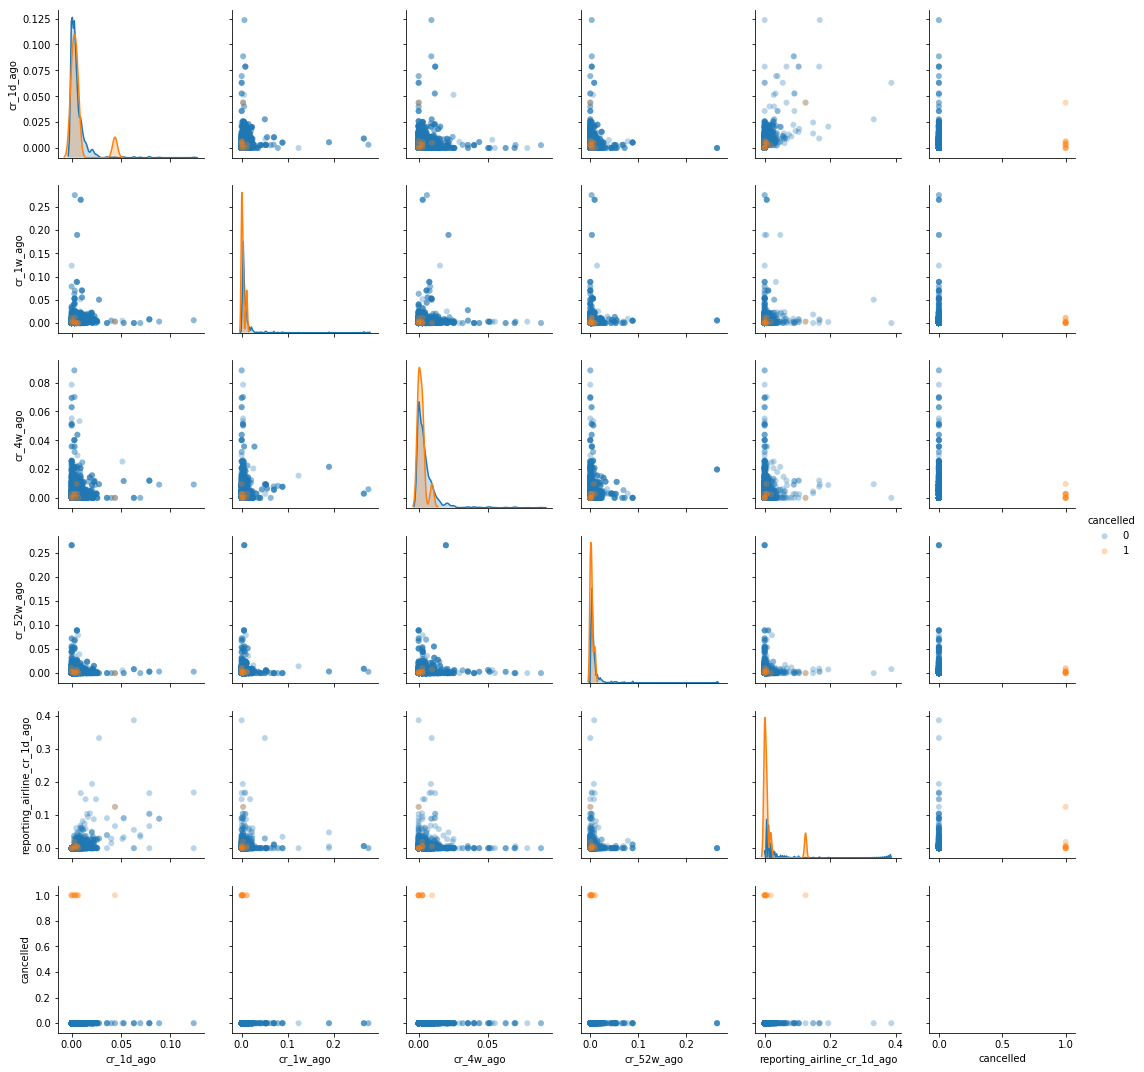

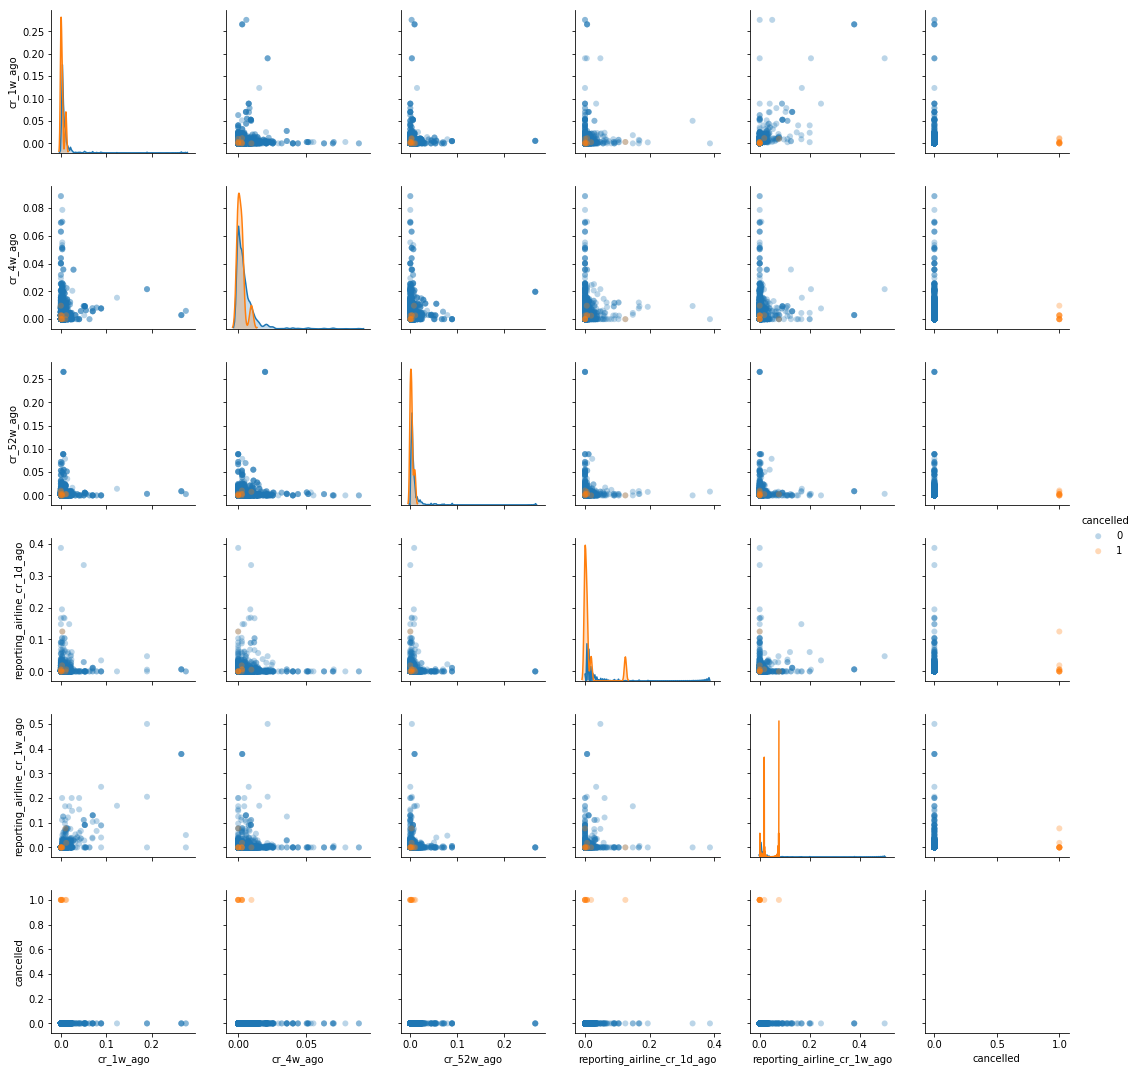

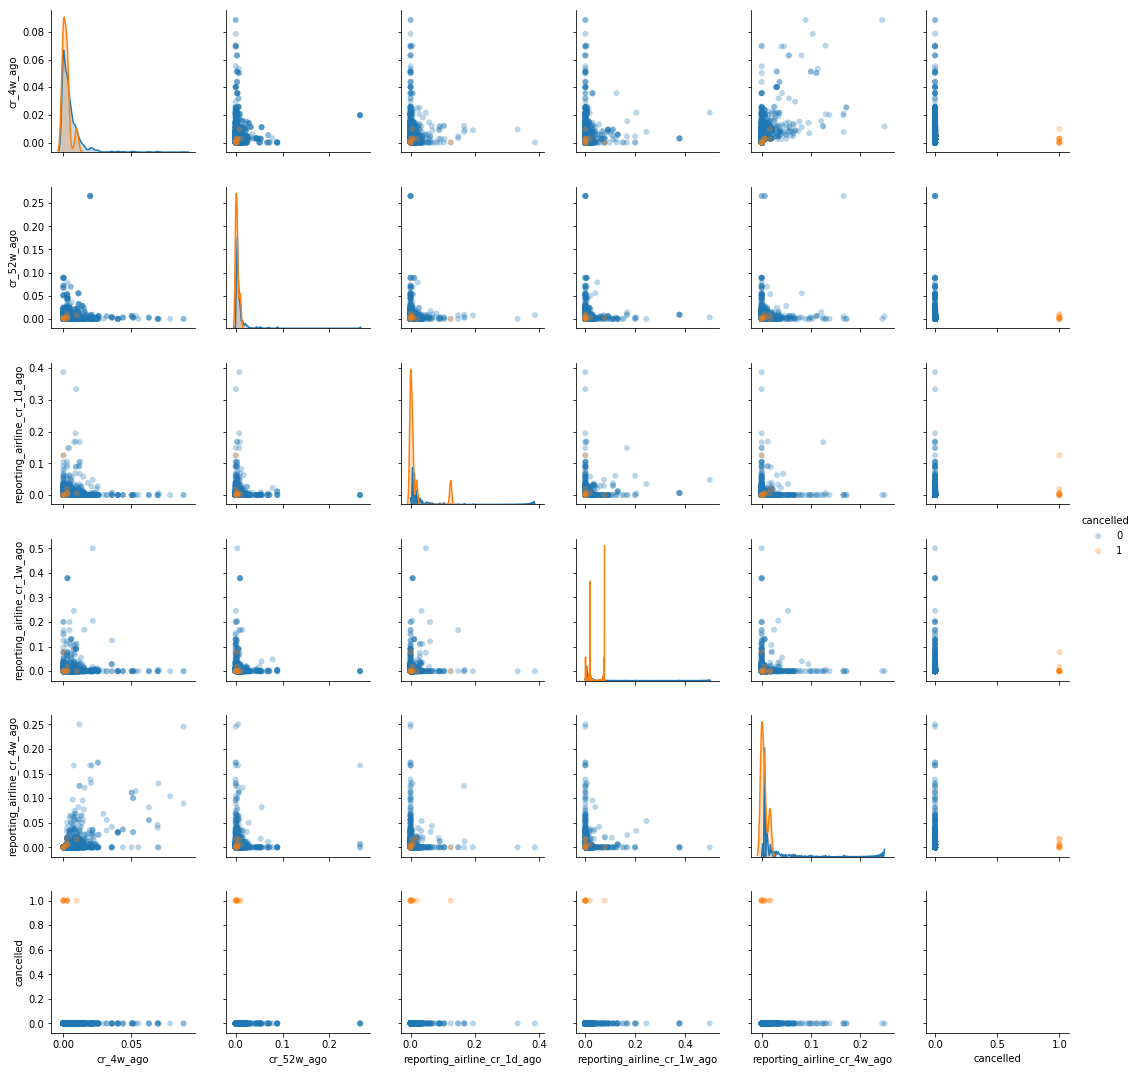

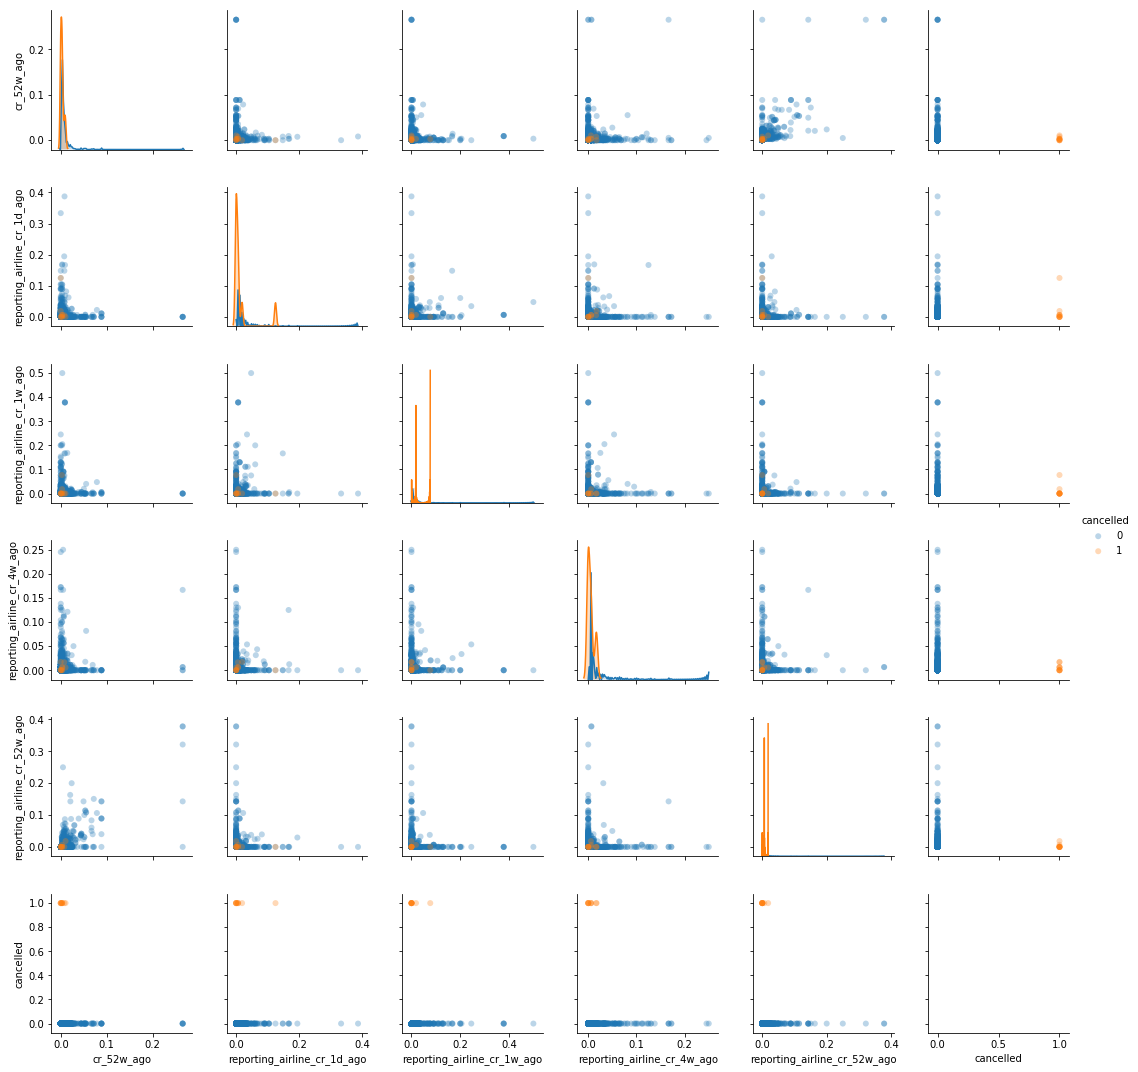

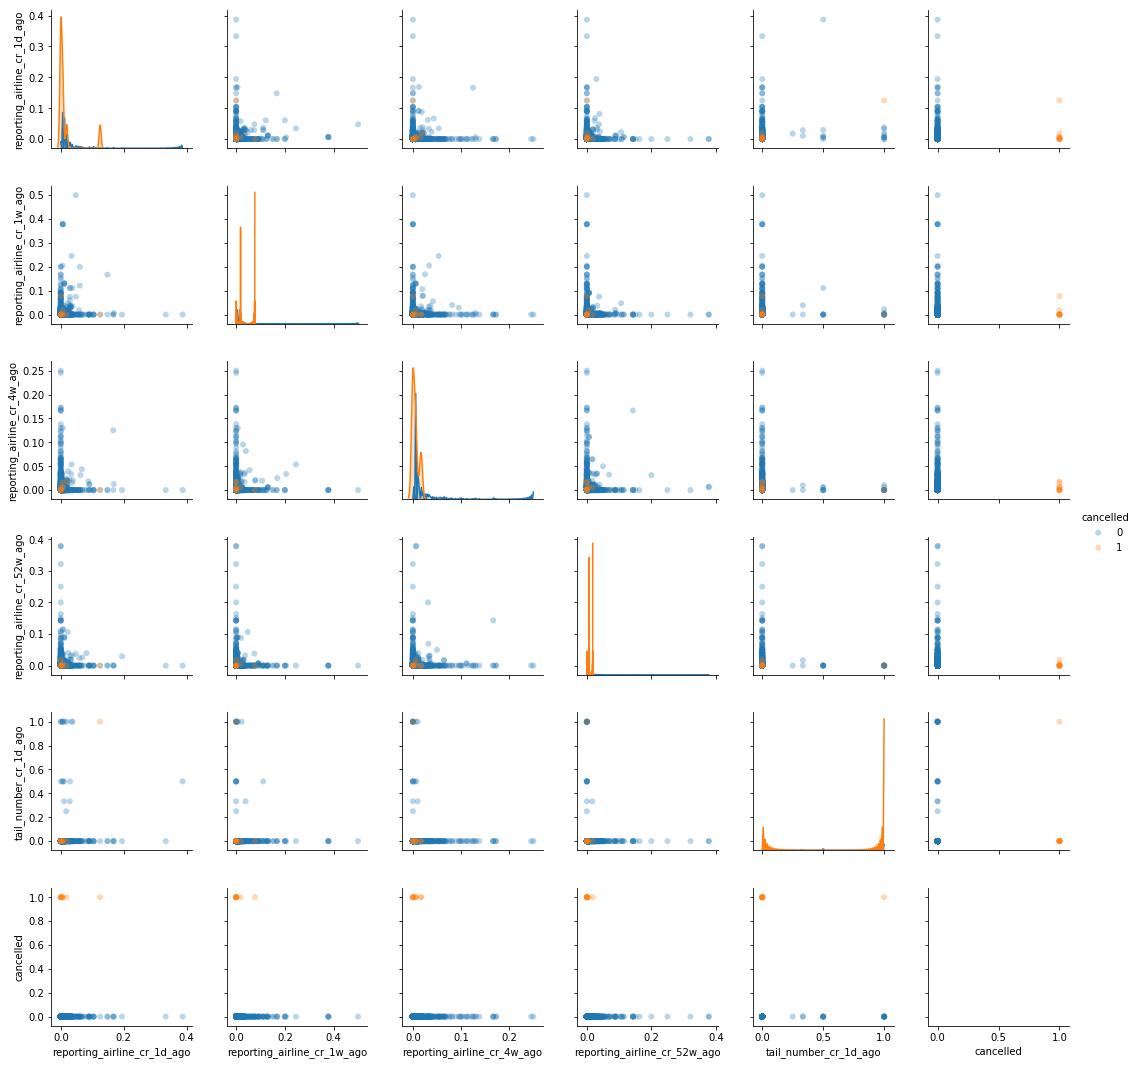

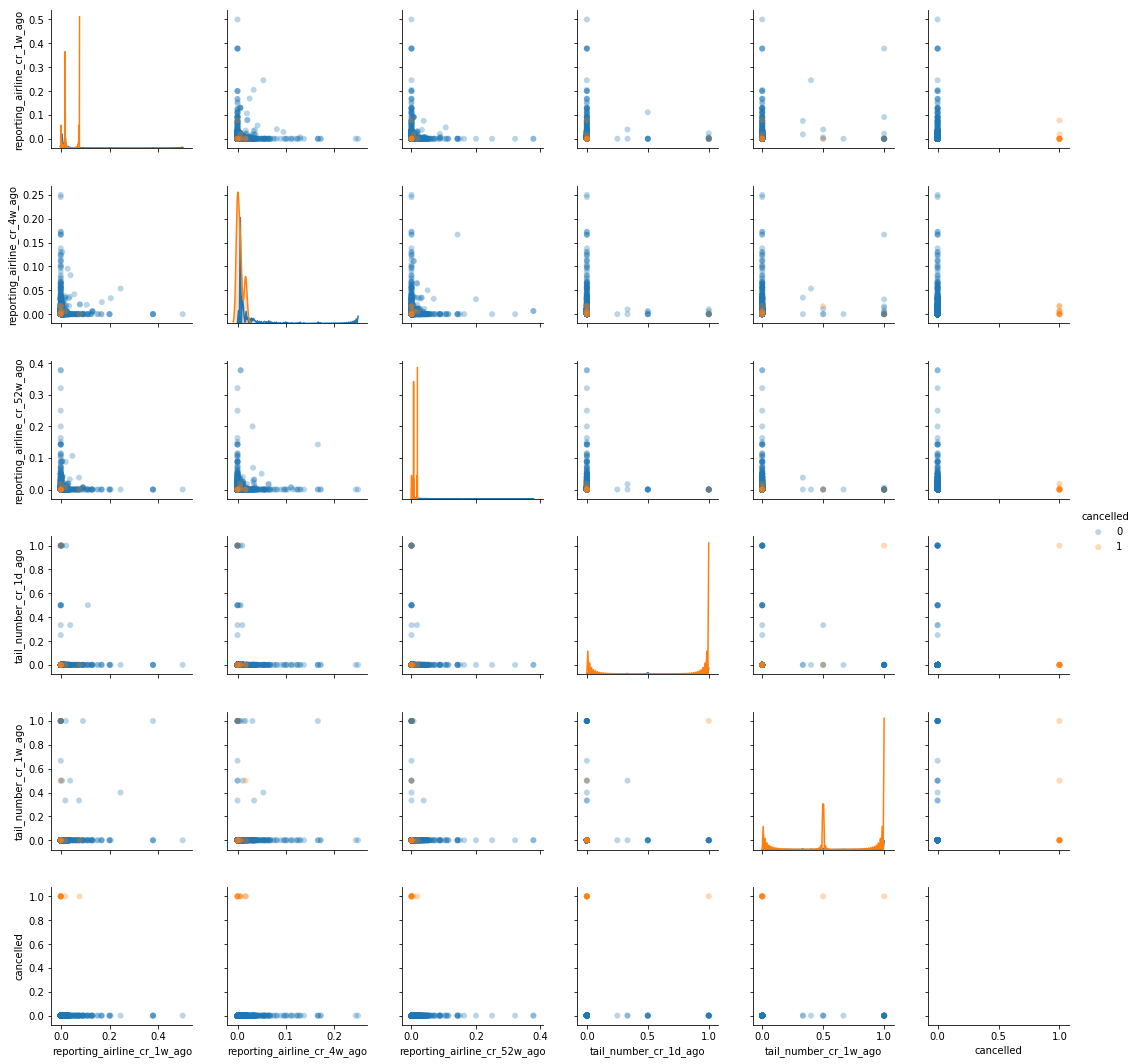

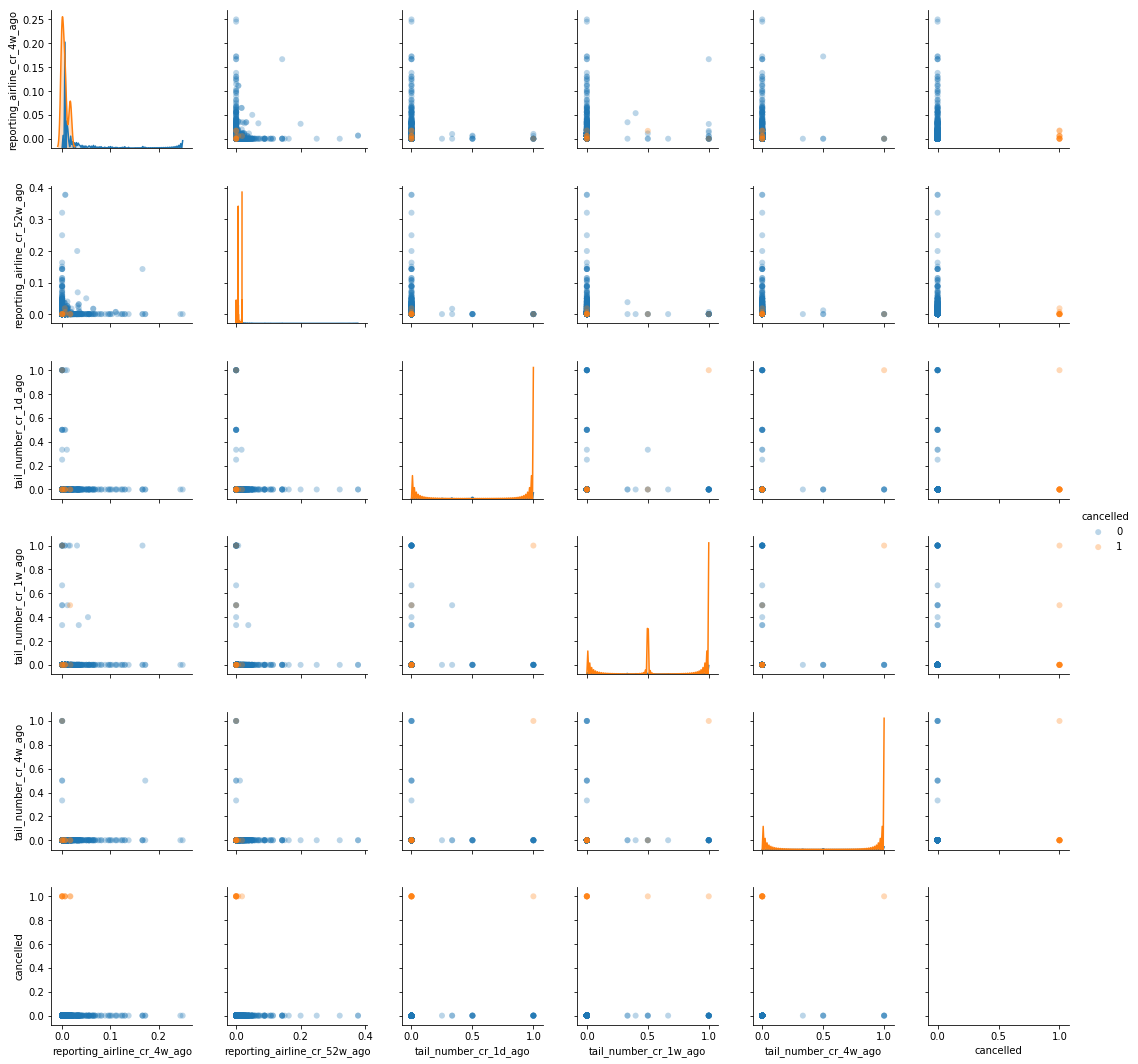

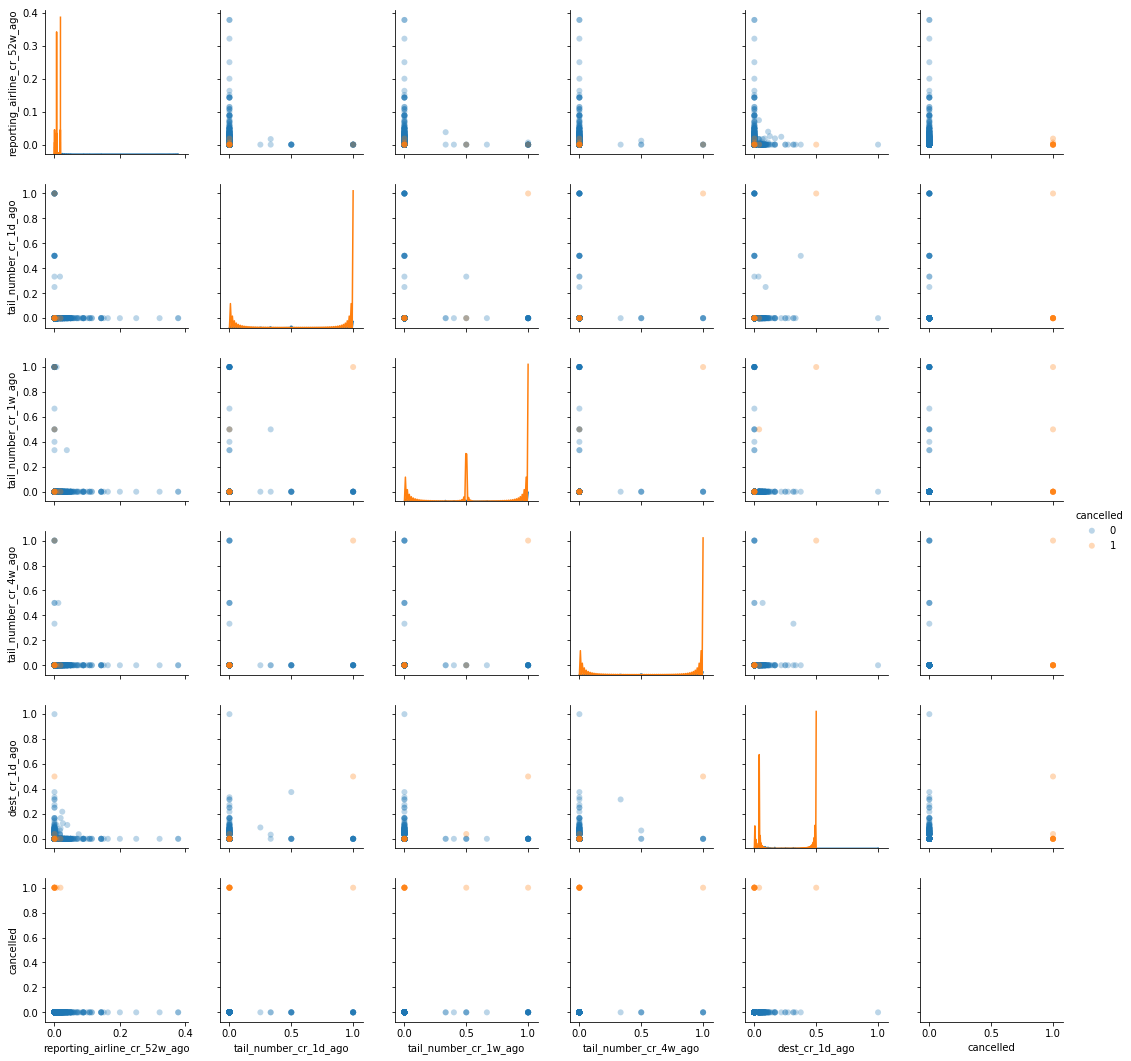

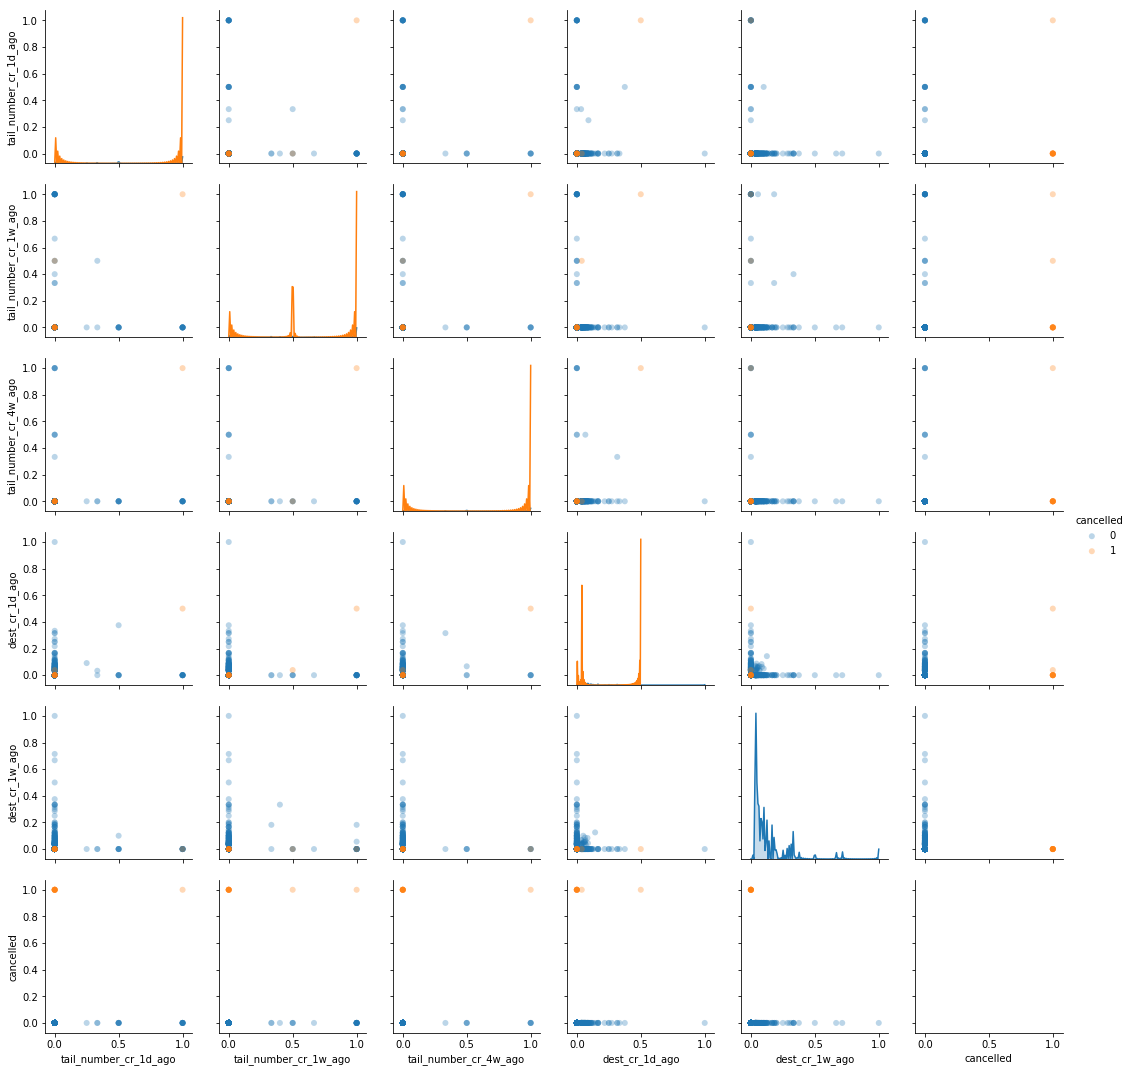

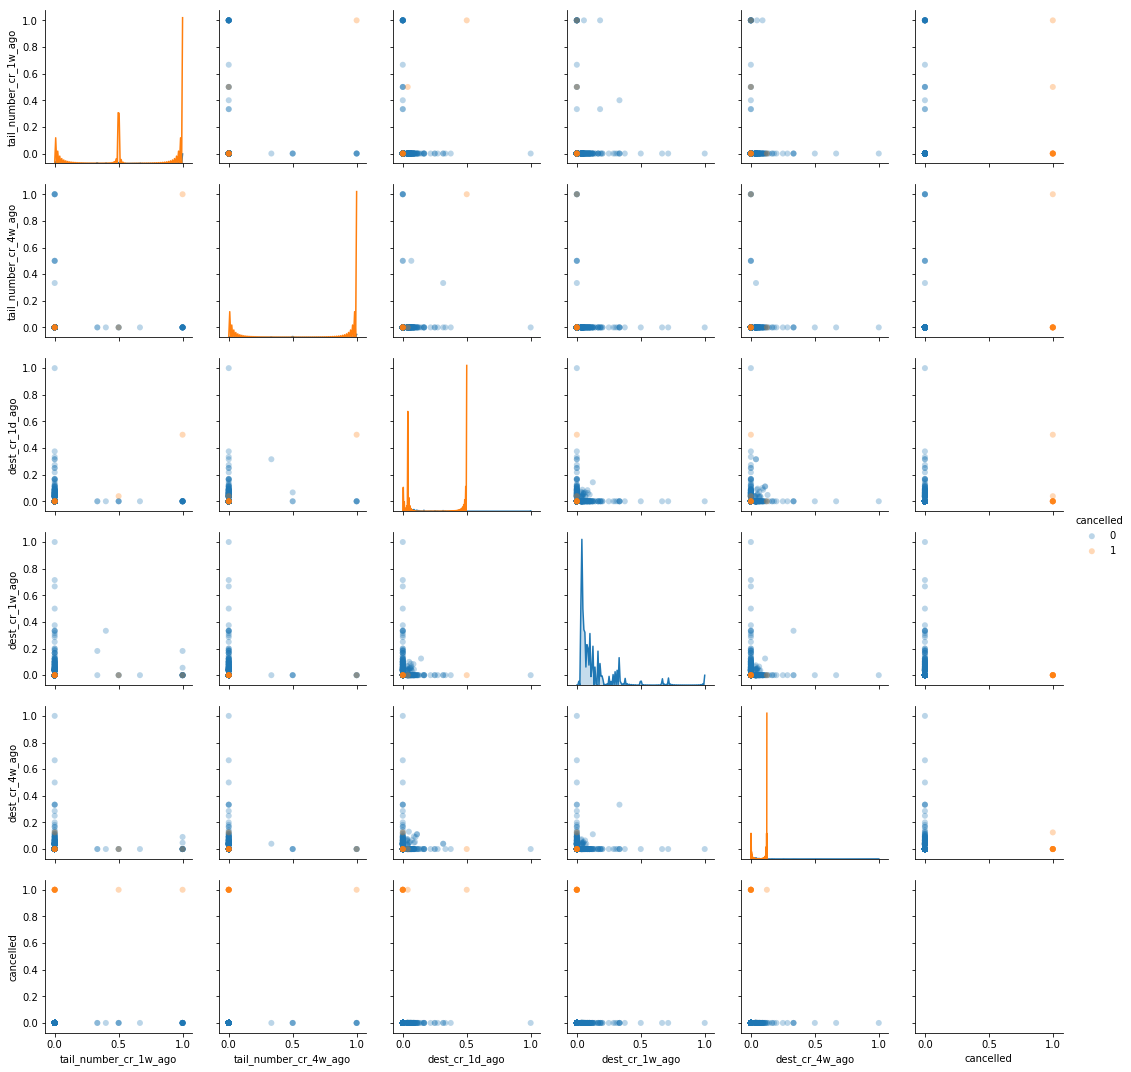

In [265]:
%time data = run()

*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [151]:
## %%writefile ../src/models/train_model.py

# Imports
import os
import time
import pickle

import numpy as np
import pandas as pd
from scipy import interp
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.model_selection import KFold, TimeSeriesSplit, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, neural_network, svm
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import ADASYN
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline


# Helper functions
def file_exists(path, filename):
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    return file_exists


def record_results(results):
    """
    Keeps track of model results.
    Input: results (dict), a dictionary of key model attributes
        Results look like:
            results = {
                'Model': 'Logistic Regression', 
                'Notes': 'Classes highly unbalanced; added weather data'
                'Features': 31,
                'Target': 'Cancelled',
                'Train/Test Observations': (320132, 82433),
                'Train Balance': {0: 316931, 1: 3201},
                'Train Score': 0.3, 
                'Test Score': 0.21,
                'Train F1': 0.3,
                'Test F1': 0.2,
                'Hyperparameters': 'solver='lbfgs', 
            }
    Output: record returned as a dataframe and stored as a pickle to persist
    """
    path = '../models/records/'
    filename = 'model_history.pkl'
    filepath = path + filename
    
    if not file_exists(path, filename):
        # If records do not exist yet, create
        columns = list(results.keys())
        record = pd.DataFrame(columns=columns)
    else:
        record = pd.read_pickle(filepath)
        
    record.loc[len(record)] = results
#     display(record.tail(10))
    pd.to_pickle(record, filepath)
    return record


def cost_function(y_actual, y_pred, k=0.1):
    """
    Assigns a score to a set of predictions which represents the proportion of
    available margin that the model captures. A score of 1 indicates perfect
    predictions, capturing all possible savings. A score of zero means that
    following the model results in a wash (i.e. no change in revenue as
    compared to not using the model). A negative score indicates that using the
    model would lose money.
    
    Assigns cost for each prediction according to the following:
        FN: 0
        FP: k - profit / margin
        TN: 0
        TP: k
        
    Values for profit and margin are averages taken from market research, but
    could be improved on if made specific to type of aircraft.
    
    Input: 
        Actual and predicted classification values as lists or listlike objects
        k (default 0.1, i.e. 10%), the proportional improvement an airline can
        make with foreknowledge of a cancellation
    Output:
        A score ranging from {1 - profit/(margin * k), 1}
    """
    profit = 1800
    margin = 2600
    
    # Costs
    d = {
        0: {0: 0,
            1: k - profit / margin},
        1: {0: 0,
            1: k},
    }
    
    classifications = np.stack((y_actual, y_pred)).T
    savings = np.sum([d[a][p] for a, p in classifications])
    score = savings / (np.sum(y_actual) * k)
    return score
    

def save_to(filepath, item):
    """
    Pickles item sand saves it to path
    Input: object to be pickled, string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(filepath, 'wb') as to_write:
        pickle.dump(item, to_write)
    return


def build_model(method, kwargs={}):
    """
    Instantiates model with given method and hyperparameters
    Input: 
        method (str), name of model to instantiate
            Model options are:
            'KNN',
            'Logistic Regression',
            'Naive Bayes',
            'Linear SVM',
            'Radial SVM',
            'Random Forest',
            'Gradient Boosting',
            'Adaptive Boosting',
            'Linear MLP',
            'Relu MLP'
        kwargs (dict, optional), dictionary of model hyperparameters. If
            omitted, will use defaults.
    Output: instantiated model
    """
    if not kwargs:
        if method == 'Linear MLP':
            kwargs = {'activation': 'identity'}
    
    models = {
        'Logistic Regression': LogisticRegression,
        'KNN': neighbors.KNeighborsClassifier,
        'Naive Bayes': GaussianNB,
        'Linear SVM': svm.LinearSVC,
        'Radial SVM': svm.SVC,
        'Random Forest': RandomForestClassifier,
        'Gradient Boosting': GradientBoostingClassifier,
        'Adaptive Boosting': AdaBoostClassifier,
        'Linear MLP': neural_network.MLPClassifier,
        'Relu MLP': neural_network.MLPClassifier
    }
    model = eval('model(**kwargs)', {'model': models[method], 'kwargs': kwargs})
    
    return model


def save_train_test(cv, holdout, path):
    """
    Saves train and test data to pickles
    Input: train and test data and path to store pickles in
    Output: pickled files in directory
    """
    save_to(path + 'cv.pkl', cv)
    save_to(path + 'holdout.pkl', holdout)
    pass


def cv_roc_curve(tprs, aucs, mean_fpr):
    """
    """
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return
    

def optimize_score(test_prob, y_test):
    scores = []
    for threshhold in np.linspace(0.5, 1, 50):
        test_pred = test_prob[:, 1] > threshhold
        score = cost_function(y_test, test_pred)
        scores.append(score)
        if max(scores) == score:
            top_thresh = threshhold
    return max(scores), top_thresh
    
def run_models(methods, cv, target, desc, pipeline):
    """
    """
    # Parameters
#     threshhold = 0.86
#     threshhold = 0.5
#     desc = f'CV - {desc}'
    
    t0 = time.time()
    for method, kwargs in methods.items():
        train_scores = []
        test_scores = []
        train_f1s = []
        test_f1s = []
        best_thresh = []
        
        # ROC-AUC params
        tprs = []
        aucs = []
        thresh = []
        mean_fpr = np.linspace(0, 1, 100)
        plt.figure()
        
        print(f'\n Training {method} Models with {kwargs}...')
        start_method = time.time()
        t1 = time.time()
        
        for i, fold in enumerate(cv):
            t2 = time.time()
            X_train = fold['X_train']
            y_train = fold['y_train']
            X_test = fold['X_test']
            y_test = fold['y_test']
            
            model = build_model(method, kwargs=kwargs)

            prob_methods = ['Linear SVM', 'Radial SVM', 'Adaptive Boosting']
            if method in prob_methods:
                model = CalibratedClassifierCV(model)

            # Train model
            model.fit(X_train, y_train)
            save_to('../models/model.pkl', model)

            # Predict and train on training set
            train_pred = model.predict(X_train)
            train_prob = model.predict_proba(X_train)
            score, threshhold = optimize_score(train_prob, y_train)
            train_pred = train_prob[:, 1] > threshhold
            train_scores.append(score)
            train_f1s.append(f1_score(y_train, train_pred))

            # Test model on testing set
            test_pred = model.predict(X_test)
            test_prob = model.predict_proba(X_test)
            test_pred = test_prob[:, 1] > threshhold
            score = cost_function(y_test, test_pred)
#             score, threshhold = optimize_score(test_prob, y_test)
#             test_pred = test_prob[:, 1] > threshhold
            test_scores.append(score)
            best_thresh.append(threshhold)
            test_f1s.append(f1_score(y_test, test_pred))
            
            # Print status
            t3 = time.time() - t2
            print(f'CV {i + 1} test score: {score} with threshhold: {threshhold}')
            print(f'\n{round(t3/60, 1)} minutes.')
            
            # ROC-AUC scores
            fpr, tpr, thresholds = roc_curve(y_test, test_prob[:, 1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            thresh.append(thresholds[0])
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        # Log results
        train_cm = confusion_matrix(y_train, train_pred)
        test_cm = confusion_matrix(y_test, test_pred)
        train_score = np.mean(train_scores)
        test_score = np.mean(test_scores)
        train_f1 = np.mean(train_f1s)
        test_f1 = np.mean(test_f1s)
        opt_thresh = np.mean(best_thresh)
        results = {
            'Model': method, 
            'Desc': f'Thresh: {round(opt_thresh, 3)}. {desc}',
            'Features': X_train.shape[1],
            'Target': target,
            'Train/Test Observations': (X_train.shape[0], X_test.shape[0]),
            'Train Balance': dict(pd.value_counts(y_train)),
            'Train Score': train_score, 
            'Test Score': test_score,
            'Train F1': train_f1,
            'Test F1': test_f1,
            'Train CM': train_cm,
            'Test CM': test_cm,
            'Hyperparameters': model.get_params(), 
        }

        cv_roc_curve(tprs, aucs, mean_fpr)
        print(f'Mean threshold of {np.mean(thresh)} from:\n{thresh}')

        t4 = time.time() - t1
        print(f'\n{method} took {round(t4/60, 1)} minutes.')
        print(model)
        results = record_results(results)
        display(results.tail(1))
        try:
            k_best_cols = pipeline.named_steps['selectkbest'].get_support()
            if method in ['Logistic Regression', 'Linear MLP', 'Relu MLP']:
                coefficients = model.coef_[0]
            elif method in ['Random Forest', 'Gradient Boosting', 'Adaptive Boosting']:
                coefficients = model.feature_importances_
            feature_performance = pd.DataFrame({
                'Features': cv[-1]['train'].drop('cancelled', axis=1).columns[k_best_cols],
                'Coefficients': coefficients}).sort_values(by='Coefficients', ascending=False)
            display(feature_performance)
        except:
            print("Can't display coefficients for this model")
    t5 = time.time() - t0
    print(f'Modeling took {round(t5/60)} minutes.')
    return 


def split_reduce(data, target, pipeline):
    """
    Splits a dictionary of train/test data into X and y and passes it through
    a feature preparation pipeline.
    Input: data dict of the form 
        {
            'train': train, 
            'test': test
            }
    Output: data dict containing transformed and reduced data of the form:
        {
            'train': train, 
            'test': test,
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            }
    """
    train, test = data['train'], data['test']
    
    X_train, y_train = train.drop(target, axis=1), train[target]
    X_test, y_test = test.drop(target, axis=1), test[target]
    
    X_train = pipeline.fit_transform(X_train, y_train)
    X_test = pipeline.transform(X_test)
    save_to('../models/pipeline.pkl', pipeline)
    
    data['X_train'] = X_train
    data['y_train'] = y_train
    data['X_test'] = X_test
    data['y_test'] = y_test
    
    return data
    
def prepare_data(cv, holdout, target, pipeline, final=0):
    """
    Splits cv and holdout data into X and y and processes X according to a data
    prep pipeline
    Input: 
        cv (list), a list of dictionaries of train/test folds
        holdout (dict), a holdout dataset for the final train/test
        target (str), the target variable
        pipeline (obj), an sklearn pipeline for processing the data
    Output: prepared forms of the cv and holdout datasets
    """
    for i, fold in enumerate(cv):
        print(f'Processing CV dataset {i + 1}...')
        fold = split_reduce(fold, target, pipeline)
    if final:
        print('Processing holdout dataset...')
        holdout = split_reduce(holdout, target, pipeline)
    return cv, holdout, pipeline
    

def train_test_split(data):
    """
    """
    start = data.index[0].year
    end = data.index[-1].year
    
    cv = []
    for i in range(start + 5, end - 1):
        cv_train = data[str(i - 5):str(i)]
        cv_test = data[str(i + 1)]
        cv.append({'train': cv_train, 'test': cv_test})
        
    ho_train = data[str(end - 6):str(end - 1)]
    ho_test = data[str(end)]
    holdout = {'train': ho_train, 'test': ho_test}
        
    return cv, holdout


def load_features(filepath):
    """
    Loads data from csv and returns as dataframe
    Input: relative filepath pointing to file
    Output: dataframe containing data from csv
    """
    data = pd.read_pickle(filepath)
    return data


def load_from(filepath):
    """
    Unpickles item and returns item from path
    Input: filepath to pickled object
    Output: unpickled object
    """
    with open(filepath, 'rb') as f:
        item = pickle.load(f)
    return item


def run(overwrite='ask', desc=''):
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    # Parameters
    path = '../data/processed/'
    target = 'cancelled'
    methods = {
        'Logistic Regression': {'penalty': 'l2', 'solver': 'lbfgs'},
#         'Logistic Regression': {'penalty': 'l1', 'solver': 'saga'},
# #        'KNN': {},
# #        'Naive Bayes': {},
# #        'Linear SVM': {},
#         'Radial SVM': {},
        'Random Forest': {'n_estimators': 200, 
                          'oob_score': True, 
                          'n_jobs': 3,
                          'class_weight': 'balanced',
                         },
# #        'Gradient Boosting': {},
        'Adaptive Boosting': {'n_estimators': 100},
        'Linear MLP': {},
        'Relu MLP': {}
    }

    score_func = f_classif
    for f in [10, 20]:#, 20, 40]:
        for k in [3, 4, 5, 7, 9, 12, 15]:        
            
            pipeline = make_pipeline(
                StandardScaler(),
                PCA(n_components=f),
                SelectKBest(score_func, k=k)
            )
            if k >= f:
                pipeline = make_pipeline(
                    StandardScaler(),
                    SelectKBest(score_func, k=k)
                )

            overwrite = 'y'

            if overwrite == 'ask':
                overwrite = input(f'Reprocess data? y/n: ')
            if overwrite.lower() != 'y':  
                print(f'Loading CV data from {path}cv.pkl')
                cv = load_from(path + 'cv.pkl')
                holdout = load_from(path + 'holdout.pkl')
            else:
                # Load data
                print(f'Loading data from {path}data.pkl')
                data = load_from(path + 'data.pkl')

                # Train-test split
                cv, holdout = train_test_split(data)

                # Prepare data for model
                print(f'Preparing data for modeling with k = {k}, f = {f}...')
                cv, holdout, pipeline = prepare_data(cv, holdout, target, pipeline)

                # Pickle data
                save_to(path + 'cv.pkl', cv)
                save_to(path + 'holdout.pkl', holdout)

            # Cross validate models using defined methods
            if not desc:
                desc = input('Describe this run: ')
            desc = f'CVT - k{k}, f{f}: {desc}'

            run_models(methods, cv, target, desc, pipeline)

    record = pd.read_pickle('../models/records/model_history.pkl')
    print('Last 5:')
    display(record.tail())
    top_5 = record.sort_values(by='Test Score', ascending=False)
    print('Top 5 so far:')
    display(top_5[top_5['Desc'].str.contains('CV')].head())
    
    return #data, model, cv_test, X_test, y_test, predictions, test_score, results


## Run model suite

In [ ]:
run(desc='Final tests')

Loading data from ../data/processed/data.pkl
Preparing data for modeling with k = 3, f = 10...
Processing CV dataset 1...
Processing CV dataset 2...
Processing CV dataset 3...


In [ ]:
path = '../data/processed/'
cv = load_from(path + 'cv.pkl')

In [135]:
record = pd.read_pickle('../models/records/model_history.pkl')
display(record.tail(15).sort_values(by='Test Score'))

Model                                               Desc  \
260           Linear MLP       CV - k: 5, f: 40, l2, others default: No PCA   
270           Linear MLP  CV - k: 15, f: 40, l2, others default: CV - k:...   
258        Random Forest       CV - k: 5, f: 40, l2, others default: No PCA   
264    Adaptive Boosting  CV - k: 10, f: 40, l2, others default: CV - k:...   
269    Adaptive Boosting  CV - k: 15, f: 40, l2, others default: CV - k:...   
259    Adaptive Boosting       CV - k: 5, f: 40, l2, others default: No PCA   
263        Random Forest  CV - k: 10, f: 40, l2, others default: CV - k:...   
266             Relu MLP  CV - k: 10, f: 40, l2, others default: CV - k:...   
267  Logistic Regression  CV - k: 15, f: 40, l2, others default: CV - k:...   
262  Logistic Regression  CV - k: 10, f: 40, l2, others default: CV - k:...   
257  Logistic Regression       CV - k: 5, f: 40, l2, others default: No PCA   
265           Linear MLP  CV - k: 10, f: 40, l2, others default: CV - k:...   
268        Random Forest  CV - k: 15, f: 40, l2, others default: CV - k:...   
271             Relu MLP  CV - k: 15, f: 40, l2, others default: CV - k:...   
261             Relu MLP       CV - k: 5, f: 40, l2, others default: No PCA   

    Features     Target Train/Test Observations         Train Balance  \
260        5  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
270       15  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
258        5  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
264       10  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
269       15  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
259        5  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
263       10  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
266       10  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
267       15  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
262       10  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
257        5  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
265       10  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
268       15  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
271       15  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   
261        5  cancelled        (875152, 119311)  {0: 871168, 1: 3984}   

     Train Score  Test Score  Train F1   Test F1  \
260     0.147703   -0.024368  0.501967  0.400802   
270     0.168049    0.088314  0.503260  0.403517   
258     0.317370    0.130216  0.518398  0.402292   
264     0.212184    0.146254  0.400986  0.321619   
269     0.226116    0.148744  0.401559  0.322143   
259     0.247952    0.148910  0.503087  0.402142   
263     0.326319    0.158117  0.596842  0.401143   
266     0.235879    0.173530  0.510892  0.407353   
267     0.243695    0.184308  0.504389  0.405560   
262     0.251681    0.187135  0.504751  0.405717   
257     0.292996    0.196665  0.505347  0.406328   
265     0.241856    0.202011  0.503477  0.406605   
268     0.505282    0.202337  0.760005  0.402680   
271     0.299695    0.210632  0.508782  0.402627   
261     0.332097    0.254787  0.502985  0.404528   

                          Train CM                    Test CM  \
260   [[871132, 36], [2682, 1302]]   [[118727, 1], [498, 85]]   
270  [[871050, 118], [2651, 1333]]   [[118728, 0], [498, 85]]   
258   [[871146, 22], [2638, 1346]]  [[118712, 16], [499, 84]]   
264   [[871130, 38], [2681, 1303]]   [[118727, 1], [498, 85]]   
269   [[871153, 15], [2684, 1300]]   [[118728, 0], [498, 85]]   
259   [[871091, 77], [2669, 1315]]   [[118725, 3], [498, 85]]   
263  [[871068, 100], [2330, 1654]]   [[118728, 0], [499, 84]]   
266  [[871065, 103], [2623, 1361]]   [[118721, 7], [499, 84]]   
267   [[871096, 72], [2667, 1317]]   [[118728, 0], [498, 85]]   
262   [[871107, 61], [2670, 1314]]   [[118728, 0], [498, 85]]   
257   [[871135, 33], [2674, 1310]]   

In [ ]:
'oob_score': True, 'n_jobs': 2

In [174]:
path = '../data/processed/'
cv = load_from(path + 'cv.pkl')
holdout = load_from(path + 'holdout.pkl')
record = pd.read_pickle('../models/records/model_history.pkl')
top_5 = record[record['Desc'].str.contains('CV')].sort_values(by='Test Score', ascending=False)
display(top_5.head(8))

Model                                               Desc  \
168           Linear SVM                 CV - CV - CV - CV - Initial CV run   
171    Adaptive Boosting                      CV - CV - CV - Initial CV run   
173             Relu MLP            CV - CV - CV - CV - CV - Initial CV run   
166                  KNN                           CV - CV - Initial CV run   
178  Logistic Regression                          CV - Tuning PCA and KBest   
189  Logistic Regression  CV - k: 10; Logistic Regression: CV - k: 8; Lo...   
183  Logistic Regression  CV - f: 32, k: 4; Logistic Regression: CV - f:...   
182  Logistic Regression  CV - f: 16, k: 8; Logistic Regression: CV - f:...   

    Features     Target Train/Test Observations         Train Balance  \
168       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
171       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
173       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
166       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
178       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
189       10  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
183        4  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   
182        8  cancelled        (888380, 121111)  {0: 884261, 1: 4119}   

     Train Score  Test Score  Train F1   Test F1                     Train CM  \
168     0.334232    0.252856  0.500952  0.398612  [[884261, 0], [2793, 1326]]   
171     0.326193    0.251883  0.492498  0.397358  [[884259, 2], [2813, 1306]]   
173     0.329387    0.250901  0.500174  0.399605  [[884259, 2], [2795, 1324]]   
166     0.333256    0.250309  0.499860  0.398447  [[884261, 0], [2795, 1324]]   
178     0.327035    0.248316  0.501837  0.399618  [[884253, 8], [2788, 1331]]   
189     0.326698    0.248264  0.501785  0.399540  [[884254, 7], [2789, 1330]]   
183     0.328284    0.248264  0.501886  0.399540  [[884254, 7], [2789, 1330]]   
182     0.326269    0.248264  0.501991  0.399540  [[884254, 7], [2789, 1330]]   

                      Test CM  \
168  [[120477, 0], [548, 86]]   
171  [[120477, 0], [548, 86]]   
173  [[120477, 0], [547, 87]]   
166  [[120477, 0], [548, 86]]   
178  [[120477, 0], [548, 86]]   
189  [[120477, 0], [548, 86]]   
183  [[120477, 0], [548, 86]]   
182  [[120477, 0], [548, 86]]   

                                       Hyperparameters  
168  {'base_estimator__C': 1.0, 'base_estimator__cl...  
171  {'base_estimator__algorithm': 'SAMME.R', 'base...  
173  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
166  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
178  {'C': 1.0, 'class_weight': None, 'dual': False...  
189  {'C': 1.0, 'class_weight': None, 'dual': False...  
183  {'C': 1.0, 'class_weight': None, 'dual': False...  
182  {'C': 1.0, 'class_weight': None, 'dual': False...

In [151]:
display(record['Hyperparameters'][194], record['Hyperparameters'][195])

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [195]:
train = cv[0]['train']
df = pd.DataFrame(train)
df.iloc[100:150]
# pd.value_counts(y_train)

cancelled est_time  distance  cr_1d_ago  cr_1w_ago  cr_4w_ago  \
date                                                                        
2008-01-01          0    211.0      1449   0.017668   0.040441   0.017422   
2008-01-01          0    163.0       954   0.017668   0.040441   0.017422   
2008-01-01          0    146.0       956   0.017668   0.040441   0.017422   
2008-01-01          0    192.0      1399   0.017668   0.040441   0.017422   
2008-01-01          0    373.0      2677   0.017668   0.040441   0.017422   
2008-01-01          0    229.0      1721   0.017668   0.040441   0.017422   
2008-01-01          0    131.0       679   0.017668   0.040441   0.017422   
2008-01-01          0    167.0      1107   0.017668   0.040441   0.017422   
2008-01-01          0    143.0       866   0.017668   0.040441   0.017422   
2008-01-01          0    151.0       956   0.017668   0.040441   0.017422   
2008-01-01          0    225.0      1449   0.017668   0.040441   0.017422   
2008-01-01          0    221.0      1449   0.017668   0.040441   0.017422   
2008-01-01          0    210.0      1660   0.017668   0.040441   0.017422   
2008-01-01          0    149.0      1024   0.017668   0.040441   0.017422   
2008-01-01          1    156.0       956   0.017668   0.040441   0.017422   
2008-01-01          0    160.0      1107   0.017668   0.040441   0.017422   
2008-01-01          0    244.0      1721   0.017668   0.040441   0.017422   
2008-01-01          0    370.0      2677   0.017668   0.040441   0.017422   
2008-01-01          0    247.0      1874   0.017668   0.040441   0.017422   
2008-01-01          0    238.0      1874   0.017668   0.040441   0.017422   
2008-01-01          0    124.0       671   0.017668   0.040441   0.017422   
2008-01-01          0    303.0      2401   0.017668   0.040441   0.017422   
2008-01-01          0     58.0       224   0.017668   0.040441   0.017422   
2008-01-01          0    199.0      1399   0.017668   0.040441   0.017422   
2008-01-01          0     81.0       399   0.017668   0.040441   0.017422   
2008-01-01          0    249.0      1874   0.017668   0.040441   0.017422   
2008-01-01          0    230.0      1660   0.017668   0.040441   0.017422   
2008-01-01          0    127.0       696   0.017668   0.040441   0.017422   
2008-01-01          0    150.0      1024   0.017668   0.040441   0.017422   
2008-01-01          0    135.0       679   0.017668   0.040441   0.017422   
2008-01-01          0    107.0       605   0.017668   0.040441   0.017422   
2008-01-01          0    149.0       954   0.017668   0.040441   0.017422   
2008-01-01          0    144.0       937   0.017668   0.040441   0.017422   
2008-01-01          0    305.0      2421   0.017668   0.040441   0.017422   
2008-01-01          0    230.0      1721   0.017668   0.040441   0.017422   
2008-01-01          0    126.0       696   0.017668   0.040441   0.017422   
2008-01-01          0    129.0       671   0.017668   0.040441   0.017422   
2008-01-01          0    156.0       987   0.017668   0.040441   0.017422   
2008-01-01          0     59.0       224   0.017668   0.040441   0.017422   
2008-01-01          0    129.0       679   0.017668   0.040441   0.017422   
2008-01-01          0    318.0      2496   0.017668   0.040441   0.017422   
2008-01-01          0    256.0      1927   0.017668   0.040441   0.017422   
2008-01-01          0    289.0      2329   0.017668   0.040441   0.017422   
2008-01-01          0    221.0      1449   0.017668   0.040441   0.017422   
2008-01-01          1    157.0       954   0.017668   0.040441   0.017422   
2008-01-01          0    218.0      1449   0.017668   0.040441   0.017422   
2008-01-01          0    380.0      2677   0.017668   0.040441   0.017422   
2008-01-01          0    160.0      1024   0.017668   0.040441   0.017422   
2008-01-01          0    192.0      1399   0.017668   0.040441   0.017422   
2008-01-01          0    145.0       937   0.017668   0.040441   0.017422   

       

In [196]:
y_train = cv[0]['y_train']
df = pd.DataFrame(y_train)
df.iloc[100:150]

cancelled
date                 
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          1
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          1
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0
2008-01-01          0

In [39]:
w = train.iloc[:, pd.np.r_[0, 30:43]]
w.head()

cancelled  apparentTemperature  cloudCover  dewPoint  humidity  \
date                                                                         
2008-01-01          0                36.62        0.59     32.45      0.85   
2008-01-01          0                34.26        0.83     32.39      0.84   
2008-01-01          0                36.62        0.59     32.45      0.85   
2008-01-01          0                36.66        1.00     32.01      0.83   
2008-01-01          1                34.26        0.83     32.39      0.84   

            precipIntensity  precipProbability  pressure  temperature  \
date                                                                    
2008-01-01              0.0                0.0   1030.08        36.62   
2008-01-01              0.0                0.0   1030.89        36.88   
2008-01-01              0.0                0.0   1030.08        36.62   
2008-01-01              0.0                0.0   1034.20        36.66   
2008-01-01              0.0                0.0   1030.89        36.88   

            uvIndex  visibility  windBearing  windGust  windSpeed  
date                                                               
2008-01-01      0.0        10.0        168.0      5.78       2.70  
2008-01-01      0.0        10.0        162.0      6.79       3.49  
2008-01-01      0.0        10.0        168.0      5.78       2.70  
2008-01-01      0.0        10.0        166.0      3.57       1.74  
2008-01-01      0.0        10.0        162.0      6.79       3.49

In [88]:
w.mean(), w.std()

(cancelled                 0.005273
 apparentTemperature      49.842802
 cloudCover                0.601329
 dewPoint                 44.019280
 humidity                  0.810470
 precipIntensity           0.002941
 precipProbability         0.110982
 pressure               1017.521372
 temperature              50.045988
 uvIndex                   0.883248
 visibility                9.907752
 windBearing             173.507813
 windGust                  3.599945
 windSpeed                 1.467325
 dtype: float64, cancelled               0.072424
 apparentTemperature    10.323539
 cloudCover              0.399202
 dewPoint                8.554491
 humidity                0.125048
 precipIntensity         0.010785
 precipProbability       0.245739
 pressure                7.263639
 temperature            10.132154
 uvIndex                 1.761466
 visibility              0.592093
 windBearing            93.002461
 windGust                3.139726
 windSpeed               1.421449
 dty

In [96]:
mu, sigma = 1, 0.025 
noise = np.random.normal(mu, sigma, w.shape)
# signal = clean_signal + noise
display(w.head(), (w * noise).head())

cancelled  apparentTemperature  cloudCover  dewPoint  humidity  \
date                                                                         
2008-01-01          0                36.62        0.59     32.45      0.85   
2008-01-01          0                34.26        0.83     32.39      0.84   
2008-01-01          0                36.62        0.59     32.45      0.85   
2008-01-01          0                36.66        1.00     32.01      0.83   
2008-01-01          1                34.26        0.83     32.39      0.84   

            precipIntensity  precipProbability  pressure  temperature  \
date                                                                    
2008-01-01              0.0                0.0   1030.08        36.62   
2008-01-01              0.0                0.0   1030.89        36.88   
2008-01-01              0.0                0.0   1030.08        36.62   
2008-01-01              0.0                0.0   1034.20        36.66   
2008-01-01              0.0                0.0   1030.89        36.88   

            uvIndex  visibility  windBearing  windGust  windSpeed  
date                                                               
2008-01-01      0.0        10.0        168.0      5.78       2.70  
2008-01-01      0.0        10.0        162.0      6.79       3.49  
2008-01-01      0.0        10.0        168.0      5.78       2.70  
2008-01-01      0.0        10.0        166.0      3.57       1.74  
2008-01-01      0.0        10.0        162.0      6.79       3.49

cancelled  apparentTemperature  cloudCover   dewPoint  humidity  \
date                                                                          
2008-01-01   0.000000            37.089238    0.570622  33.012417  0.838525   
2008-01-01   0.000000            35.720645    0.820804  31.612516  0.821237   
2008-01-01   0.000000            35.334436    0.616558  33.463911  0.853230   
2008-01-01   0.000000            37.871373    1.028927  32.352808  0.839571   
2008-01-01   0.970953            34.711231    0.812468  31.042820  0.813728   

            precipIntensity  precipProbability     pressure  temperature  \
date                                                                       
2008-01-01              0.0                0.0   986.237012    38.274482   
2008-01-01              0.0                0.0  1059.231962    35.574980   
2008-01-01              0.0                0.0  1020.585389    37.017521   
2008-01-01              0.0                0.0  1054.919563    36.751048   
2008-01-01              0.0                0.0  1046.061525    37.569620   

            uvIndex  visibility  windBearing  windGust  windSpeed  
date                                                               
2008-01-01      0.0   10.383639   166.036195  5.748995   2.855590  
2008-01-01      0.0   10.111361   161.346839  6.820028   3.429377  
2008-01-01      0.0   10.213436   171.964698  5.909370   2.701845  
2008-01-01      0.0   10.188148   169.003752  3.661811   1.751554  
2008-01-01      0.0   10.185969   158.132802  6.878605   3.384057

In [110]:
# d = w.reset_index()
# d.set_index(pd.DatetimeIndex(d['date']))
d = w.copy()
d.index + pd.Timedelta('1 day')

DatetimeIndex(['2008-01-02', '2008-01-02', '2008-01-02', '2008-01-02',
               '2008-01-02', '2008-01-02', '2008-01-02', '2008-01-02',
               '2008-01-02', '2008-01-02',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='date', length=462166, freq=None)

In [113]:
def add_forecast(weather):
    """
    
    """
    data = weather.copy()
    data['date'] = pd.to_datetime(weather['next_day']) - pd.Timedelta('1 day')
    data = data.set_index('date', 'deptimeblk')
    data = weather.drop('next_day')

    # Define noise matrix
    mu, sigma = 1, 0.025 
    noise = np.random.normal(mu, sigma, data.shape)
    
    forecast = data * noise
    forecast.reset_index
    
    weather = weather.merge(
        forecast, how='left', 
        left_on=['next_day', 'deptimeblk'],
        right_on=['date', 'deptimeblk']
    ).drop('next_day')
    
    return weather

add_forecast(w)

KeyError: 'next_day'

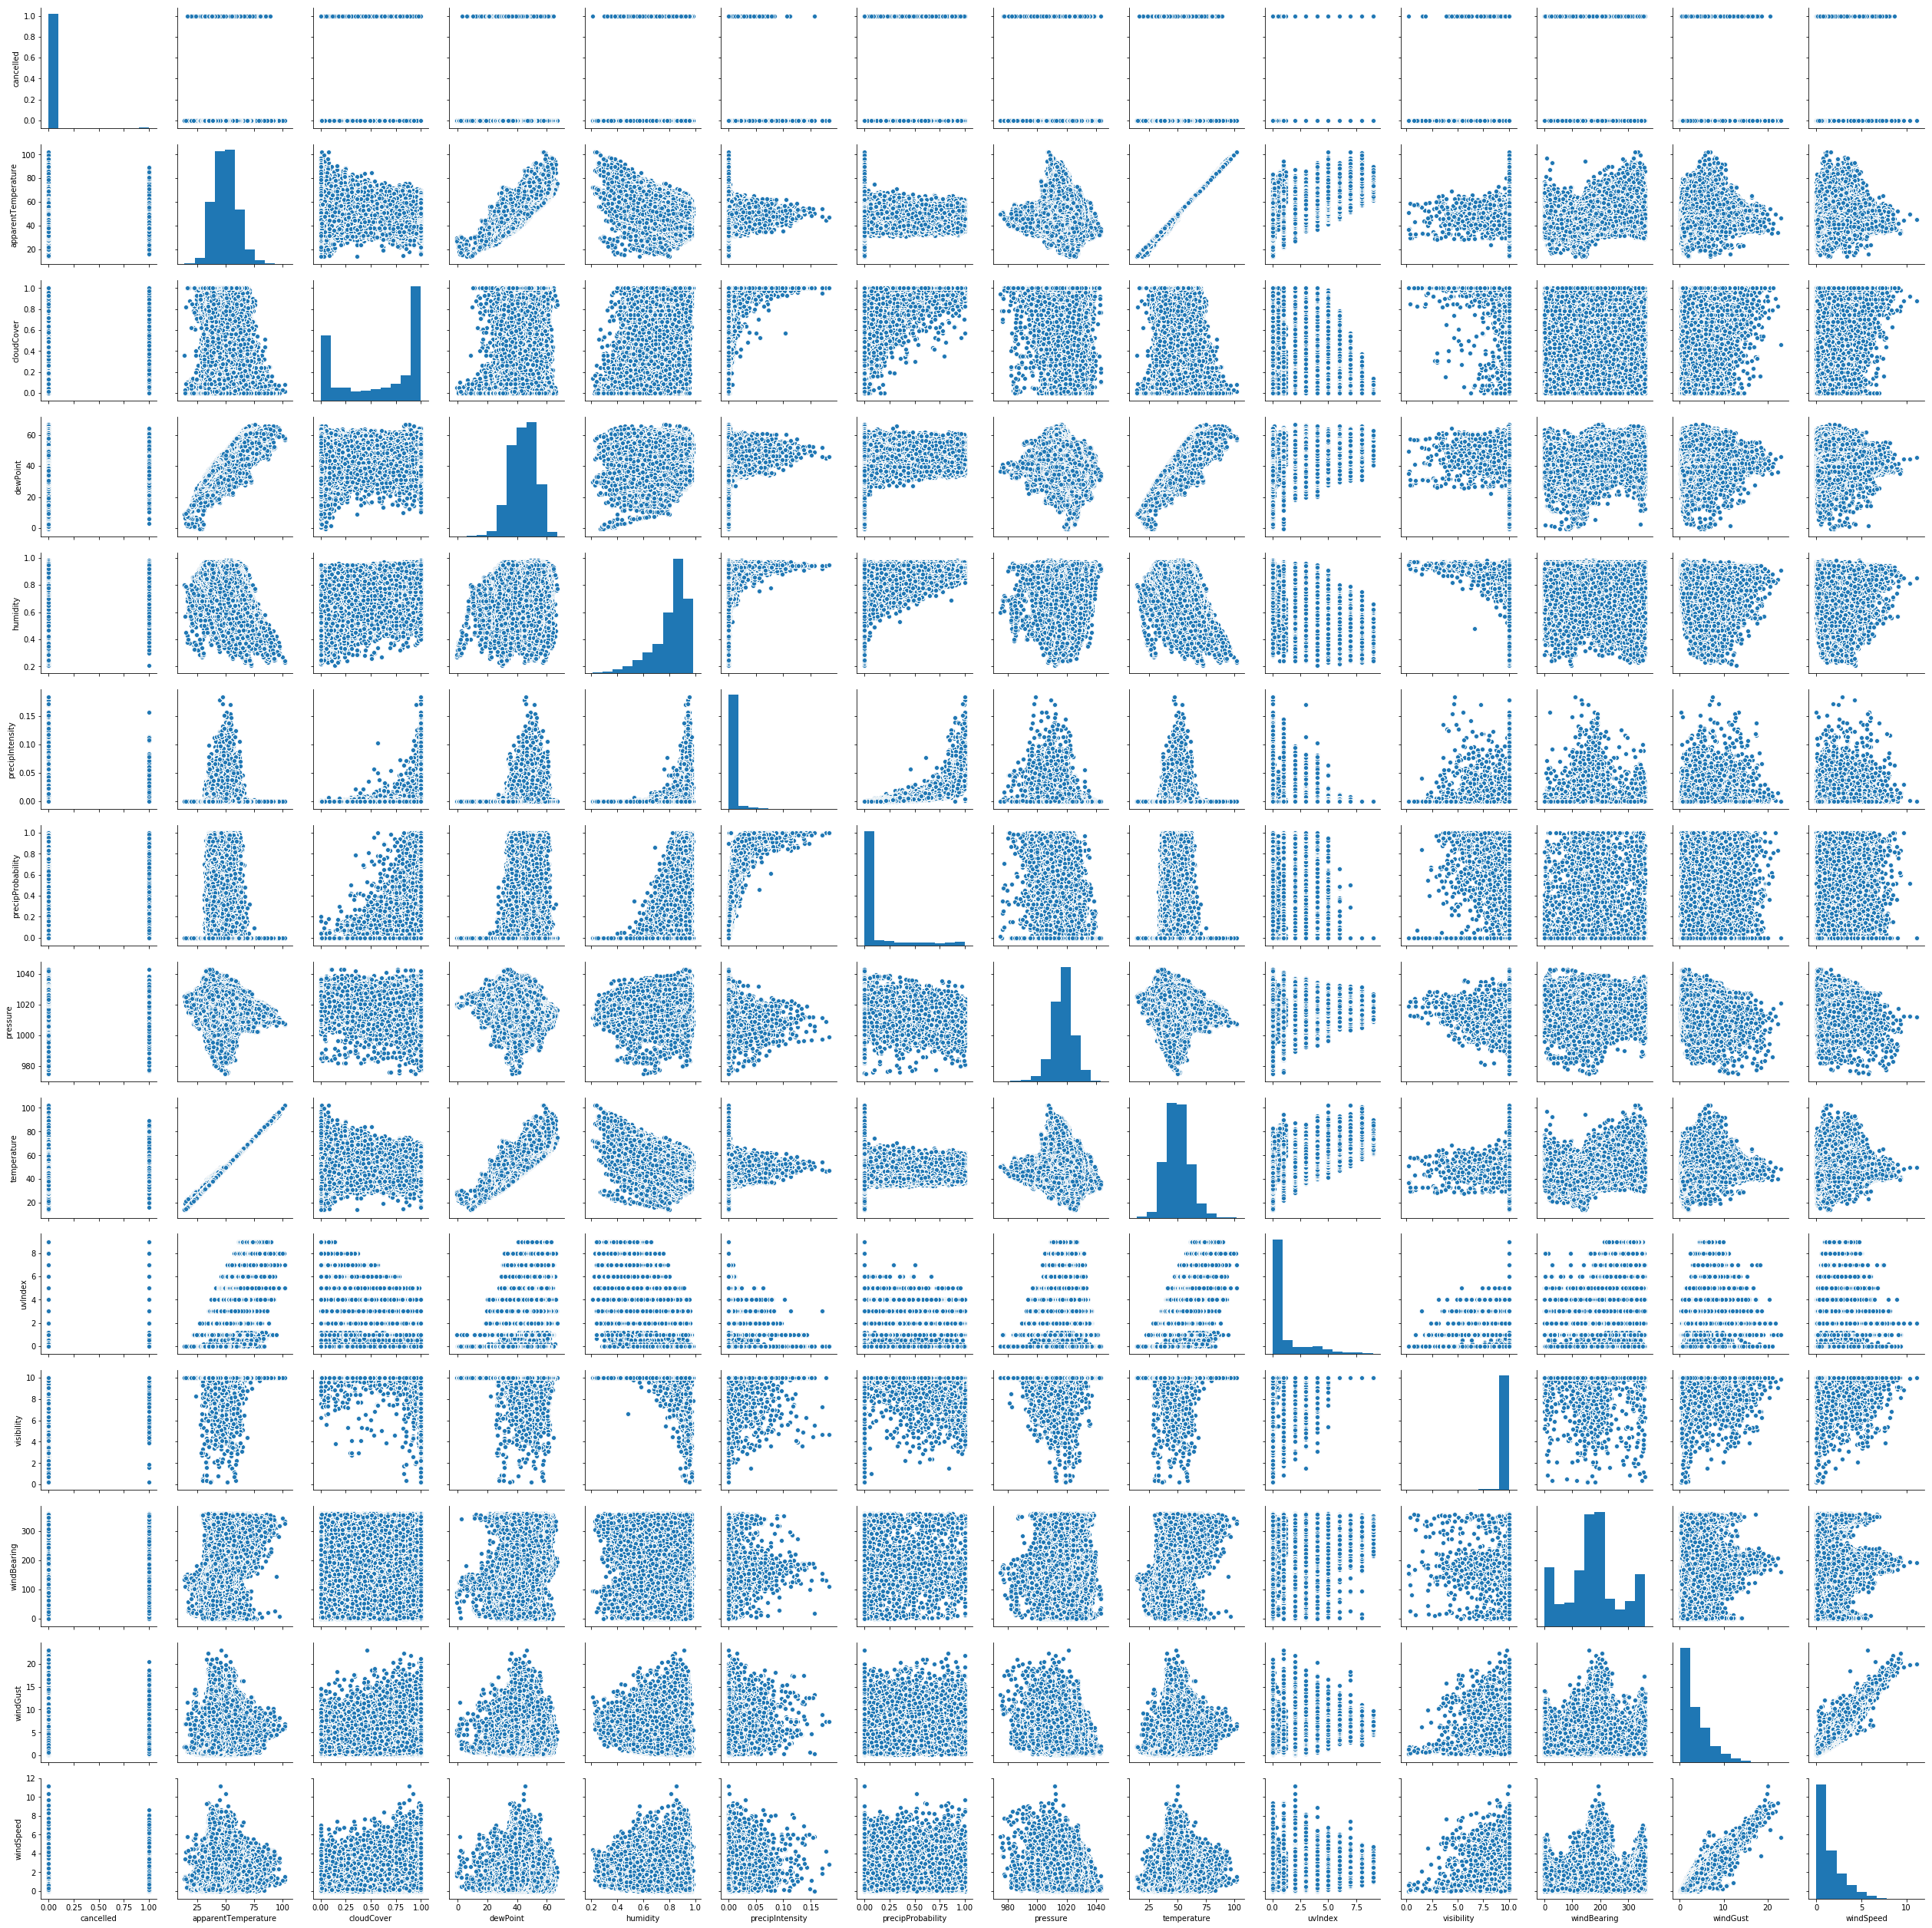

In [38]:
sns.pairplot(w)

## Scoring Metric
Based on data from [this site](<https://247wallst.com/services/2014/10/29/the-high-cost-of-cancelled-airline-flights/>):
* On average, a cancellation costs an airline about \$5,770
* That breaks down to about \$3,205 for flights canceled due to an uncontrollable event like weather
* And more like \$9,615 if the cancellation was due to something the airline should have been able to control, such as missing flight crew or maintenance.
* What that means is that about 45% of costs incurred due to cancellations *were avoidable*
* This is extra money goes towards things like inefficient usage of flight and maintenance crews as well as rebooking/reimbursing disgruntled passengers
* This means that on average about $2600 of the money lost due to a cancelled flight is money that the airline didn't have to lose. That's our margin to save from.

This project rests on the assumption that, with sufficient foreknowledge of an impending cancellation, an airline can take early actions in anticipation and cut down on that waste. The scoring function used to validate models is based on this framework, and is parametrically defined in relation to an estimated percentage that an airline can save if they can cancel a flight a day in advance and take cost-saving action then.

From this interpretation, these are my modeled costs of each possible outcome (where *k* is the proportion of the avoidable cost margin that the airline can save with a day's notice, *margin* is the total amount of loss that an airline could possibly avoid due to a cancelled flight (assumed to be \$2,600 on average), and *profit* is the amount of profit the airline would have made if the flight weren't cancelled (assumed to be \$1,800 on average)):

| Result Type    | Interpretation                                            | Savings Proportion        |
| -------------- | --------------------------------------------------------- | ------------------------- |
| False negative | Correctly predicts that a flight would not be cancelled   | $0$                       |
| False positive | Incorrectly predicts that a flight would be cancelled     | $k-\frac{profit}{margin}$ |
| True negative  | Incorrectly predicts that a flight would not be cancelled | $0$                       |
| True positive  | Correctly predicts that a flight would be cancelled       | $k$                       |

The best model is one that maximizes the recovery of losses due to cancellation--that is, minimizes loss. To quantify that, we apply apply the predicted savings proportions above to the predictions output by our model and normalize the sum against the total margin that could have been recovered across all flights in within the testing set. That is,

 $$ Savings = \frac {\sum Predictions * Reward} { Total Potential Savings} $$ or $$ C M  $$

The metric indicates that an airline would decrease their losses by $ Savings * 100\% $ by following the model's predictions. Put simply, values above 0 are good, 0 means that there'd be no change in revenue from current practices, and values less than 0 would mean that following the model will actually be more expensive for the airline. 

Further interpretation of the costs is as follows: 
* A true positive gets a boost of $k$, as these are the instances where the airline saves money
* Both true and false negatives are treated as nominal results with no penalty, as they would result in no change in current behavior (naively assuming airlines aren't already following a prediction model like this). 
* A false positive incurs the same $k$ cost as in a true positive, since the airline would "efficiently" cancel their flight, but is also penalized by a factor of $profit / margin$ to represent the lost profits the airline would have seen had the model not made the incorrect prediction.

## Confidence Interval

I can be X% sure that a flight is going to be canceled.
x times out of 100, a flight gets canceled.
If I can predict one right, I gain k.
If I predict it's canceled when it's not, I lose $$ k - \frac {profit} {margin} $$.
Predictions about the plane taking off are the null hypothesis, and not interesting.

The threshold for profitability is at:
$$ [TN TP] * [ k - \frac {profit} {margin} , k ] $$

$$
\begin{bmatrix} k - \frac {profit} {margin} & k \end{bmatrix}
\begin{bmatrix} FP \\ TP \end{bmatrix}
 = 0
$$

that's effectively the same as

$$ Savings = \beta_{00} * P_0 + \beta_{11} * P_1 $$

Where the betas are your false/true cost/benefits,  and P_0 and P_1 are the proportions of your positive cancellation predictions that you got incorrect/correct, respectively. 

Thus to solve for the minimum probability threshhold, we set the constraint that FP and TP sum to 1 (percent) and solve for TP. 

Applying our assumptions,

$$ TP = 5.92 * FP = 5.92 * (1 - TP) $$

$$ => TP = 0.86  \ or \ 86\% $$

As a result, the probability threshhold for our models should be set such that we only classify a prediction as positive if we exceed 86% confidence in our prediction.

_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_